In [1]:
from Environments import *

Step number 1, choose action:  0


 dx=1.00,dy=0.00, <class 'sympy.core.numbers.One'>, <class 'sympy.core.numbers.Float'>


AttributeError: 'One' object has no attribute 'arctan2'

In [1]:
class Settings:
    def __init__(self):
        self.road_function = sin(x)
        self.road_width    = 1
        self.road_length   = 10
        self.closed        = closed
        self.road_resulotion = 1000


In [1]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(50):
    action = input(f"Step number {i+1}, choose action: ")
    if action == 'q':
        break
    carenv.move(float(action))
    distance, closest_segment, closest_t = roadenv.distance_road_center(carenv.x, carenv.y)
    distance, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_segment, closest_t)
    if not  out_of_road:
        #round the direction to 2 decimal points
        print(f"   Distance: {distance:.2f}, Direction: {direction:.2f}, carenv.theta: {carenv.theta:.2f}, difection diff Direction: {abs(direction - carenv.theta):.2f}, Out of road: {out_of_road}")
        print(f" ")
    if i>2:
        plt.close('all')
        





    Visualize(roadenv, carenv, settings)

NameError: name 'Settings' is not defined

In [ ]:
import math
import sympy as sp
import numpy as np
from scipy.optimize import minimize_scalar

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class Settings:
    def __init__(self):
        # road settings
        self.road_function = lambda x: 2*sp.sin(x)
        self.road_width    = 1
        self.road_length   = 15
        self.closed        = True
        self.road_resulotion = 1000

        # car settings

        # car initail position
        self.init_car_x = 0
        self.init_car_y = 0
        self.init_car_theta = 0
        self.init_car_speed = .2



class RoadEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = sp.Symbol('x')
        self.y = sp.sympify(self.settings.road_function(self.x))

    def get_road_limits(self):
        # Calculate the derivative of the road function
        dy_dx = sp.diff(self.y, self.x)

        # Calculate the normal vector
        normal_x = -dy_dx / sp.sqrt(1 + dy_dx ** 2)
        normal_y = 1 / sp.sqrt(1 + dy_dx ** 2)

        # Calculate the road limits
        half_width = self.settings.road_width / 2
        left_x = self.x + normal_x * half_width
        left_y = self.y + normal_y * half_width
        right_x = self.x - normal_x * half_width
        right_y = self.y - normal_y * half_width

        # Create lambda functions for the road limits
        road_limits = {
            'left': sp.lambdify(self.x, (left_x, left_y), 'numpy'),
            'right': sp.lambdify(self.x, (right_x, right_y), 'numpy'),
            'center': sp.lambdify(self.x, (self.x, self.y), 'numpy')
        }

        return road_limits
    
    
    
    
    def distance_road_center(self, x, y):
        # Define the road center function
        road_center = sp.lambdify(self.x, self.y, 'numpy')

        # Define a function to minimize (distance between point and road)
        def distance_func(t):
            return (t - x) ** 2 + (road_center(t) - y) ** 2

        # Find the closest point on the road
        result = minimize_scalar(distance_func, bounds=(0, self.settings.road_length), method='bounded')
        closest_x = result.x
        closest_y = road_center(closest_x)

        # Calculate the distance
        distance = np.sqrt((x - closest_x) ** 2 + (y - closest_y) ** 2)

        return distance, closest_x
    
    
    def road_direction_and_terminal(self, distance, closest_x):
        if distance > self.settings.road_width / 2:
            return None, None, None, True

        # Calculate the direction of the road at the closest point
        dy_dx = sp.diff(self.y, self.x)
        road_direction = sp.lambdify(self.x, dy_dx, 'numpy')
        direction = np.arctan(road_direction(closest_x))

        return distance,road_direction(closest_x), direction, False

class CarEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def car_reset():
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def move(self, steering_angle):
        # Update the car position
        self.x += self.speed * np.cos(self.theta)
        self.y += self.speed * np.sin(self.theta)
        self.theta = (self.theta +steering_angle) % (2 * np.pi)
        self.trejectory.append((self.x, self.y))


def Visualize(roadenv, carenv, settings):
    road_limits = roadenv.get_road_limits()

    # Generate x values for plotting
    x = np.linspace(0, settings.road_length, 1000)

    # Get road limits
    left_road_limit = road_limits['left'](x)
    right_road_limit = road_limits['right'](x)
    center_road_limits = road_limits['center'](x)

    # Plot the road with gray backround

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(left_road_limit[0], left_road_limit[1], '-', color='gold', label='Road edge')
    ax.plot(right_road_limit[0], right_road_limit[1], '-', color='gold')
    ax.plot(center_road_limits[0], center_road_limits[1], 'w--', label='Center line')


    ax.set_facecolor('gray')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Road Visualization')
    ax.legend()

    # Ensure the aspect ratio is equal
    ax.set_aspect('equal', 'box')

    # Plot the car as an arrow and the trejectory in red
    arrow_length = 0.3
    ax.arrow(carenv.x, carenv.y, arrow_length*np.cos(carenv.theta), arrow_length*np.sin(carenv.theta), head_width=0.2, head_length=0.1, fc='r', ec='r', label='Car')
    ax.plot(*zip(*carenv.trejectory), 'r--', label='Trejectory')



    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(5):
    carenv.move(np.random.uniform(-.5, .5))
    distance, closest_x = roadenv.distance_road_center(carenv.x, carenv.y)
    distance,road_direction, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_x)
    if not  out_of_road:
        print(f"Distance: {distance},road_direction ={road_direction}, Direction: {direction}, carenv.theta: {carenv.theta}, Out of road: {out_of_road}")
        print(f"                    , Direction: {abs(direction - carenv.theta)}")



Visualize(roadenv, carenv, settings)

In [1]:
import numpy as np
dire = np.linspace(0, 2*np.pi, 100)

for i in dire:
    dy = np.sin(i)
    dx = np.cos(i)
    print(f' x = {dx}, y= {dy}, tan = {np.arctan2(dy, dx)}')

 x = 1.0, y= 0.0, tan = 0.0
 x = 0.9979866764718844, y= 0.0634239196565645, tan = 0.06346651825433926
 x = 0.9919548128307953, y= 0.12659245357374926, tan = 0.12693303650867852
 x = 0.9819286972627067, y= 0.18925124436041021, tan = 0.1903995547630178
 x = 0.9679487013963562, y= 0.2511479871810792, tan = 0.2538660730173571
 x = 0.9500711177409454, y= 0.31203344569848707, tan = 0.3173325912716962
 x = 0.9283679330160726, y= 0.3716624556603276, tan = 0.38079910952603563
 x = 0.9029265382866212, y= 0.42979491208917164, tan = 0.44426562778037487
 x = 0.8738493770697849, y= 0.4861967361004687, tan = 0.5077321460347141
 x = 0.8412535328311812, y= 0.5406408174555976, tan = 0.5711986642890533
 x = 0.8052702575310586, y= 0.5929079290546404, tan = 0.6346651825433925
 x = 0.766044443118978, y= 0.6427876096865393, tan = 0.6981317007977318
 x = 0.7237340381050702, y= 0.690079011482112, tan = 0.7615982190520711
 x = 0.6785094115571322, y= 0.7345917086575333, tan = 0.8250647373064104
 x = 0.6305526670

Step number 1, choose action:  0


 dx=1.00,dy=0.00, direction = 0.00
   Distance: 0.00, Direction: 0.00, carenv.theta: 0.00, difection diff Direction: 0.00, Out of road: False
 


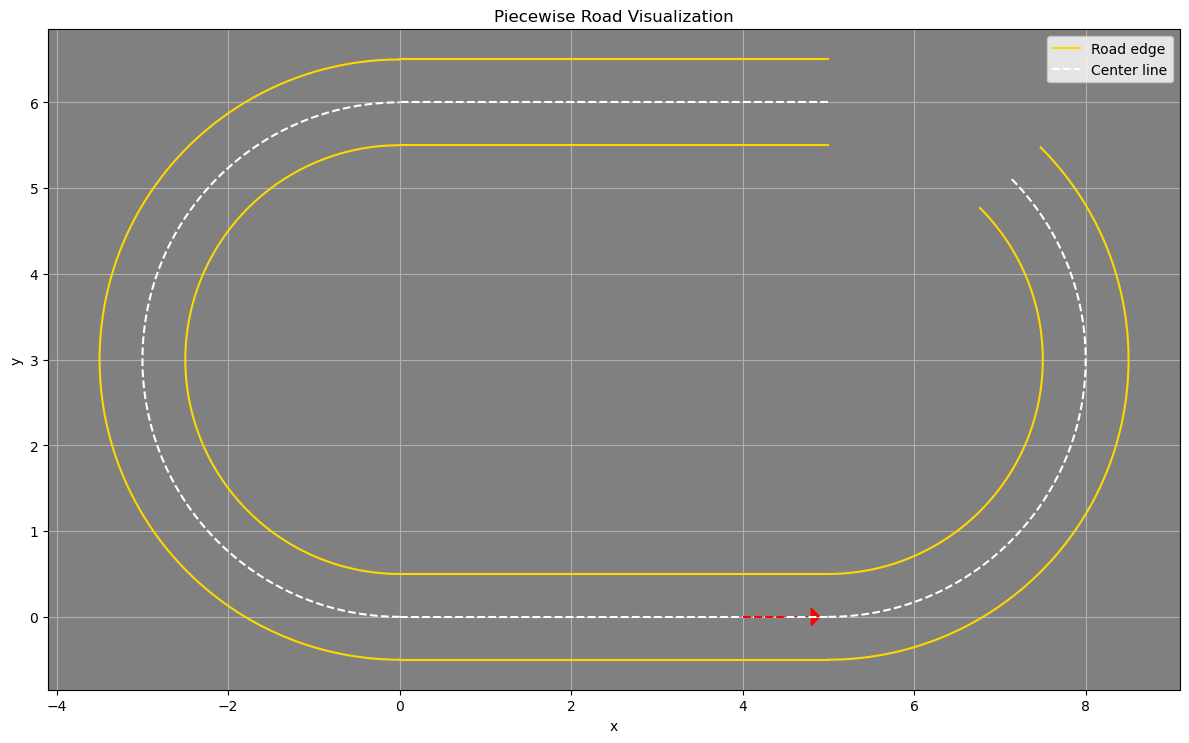

Step number 2, choose action:  .1


 dx=1.00,dy=0.00, direction = 0.00
   Distance: 0.00, Direction: 0.00, carenv.theta: 0.10, difection diff Direction: 0.10, Out of road: False
 


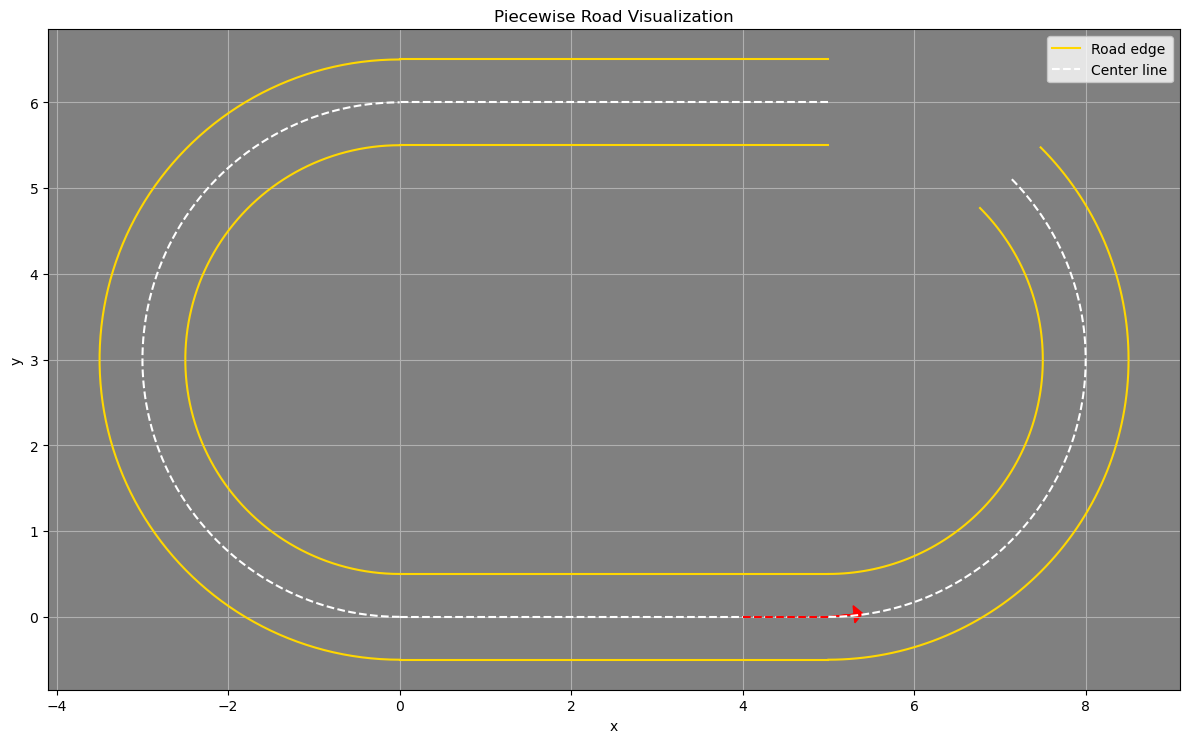

Step number 3, choose action:  .1


 dx=9.29,dy=1.57, direction = 0.17
   Distance: 0.01, Direction: 0.17, carenv.theta: 0.20, difection diff Direction: 0.03, Out of road: False
 


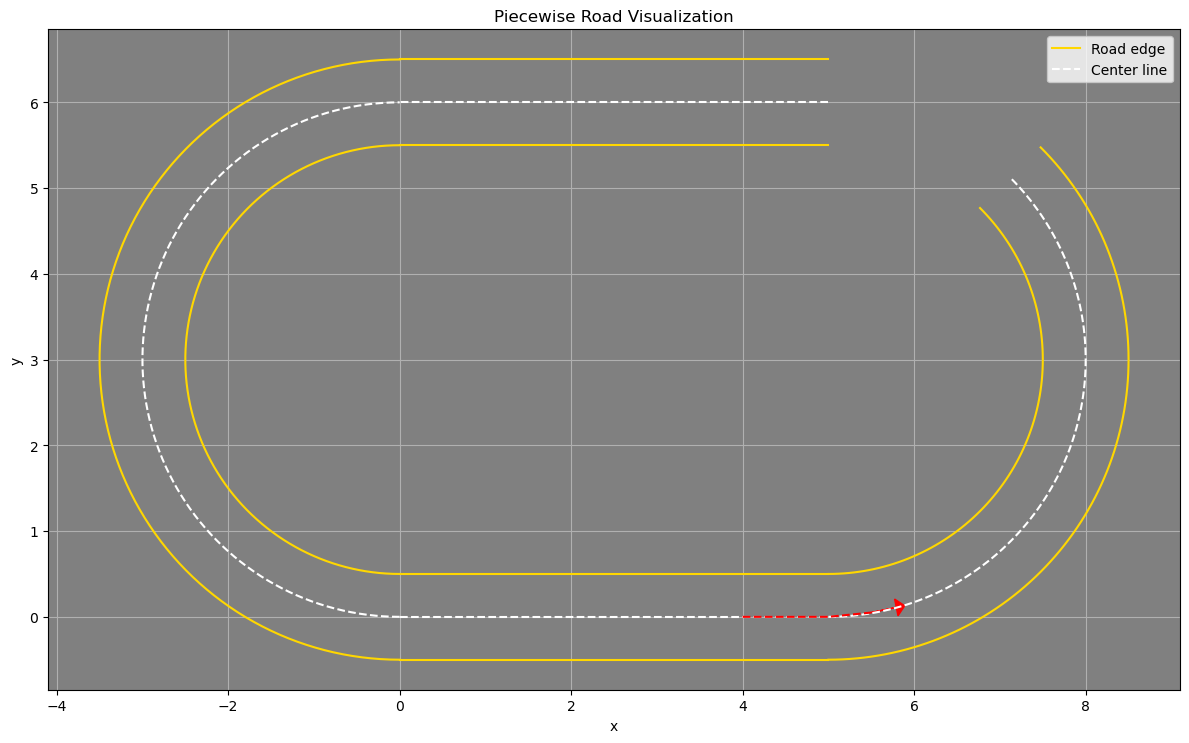

Step number 4, choose action:  .1


 dx=8.91,dy=3.09, direction = 0.33
   Distance: 0.02, Direction: 0.33, carenv.theta: 0.30, difection diff Direction: 0.03, Out of road: False
 


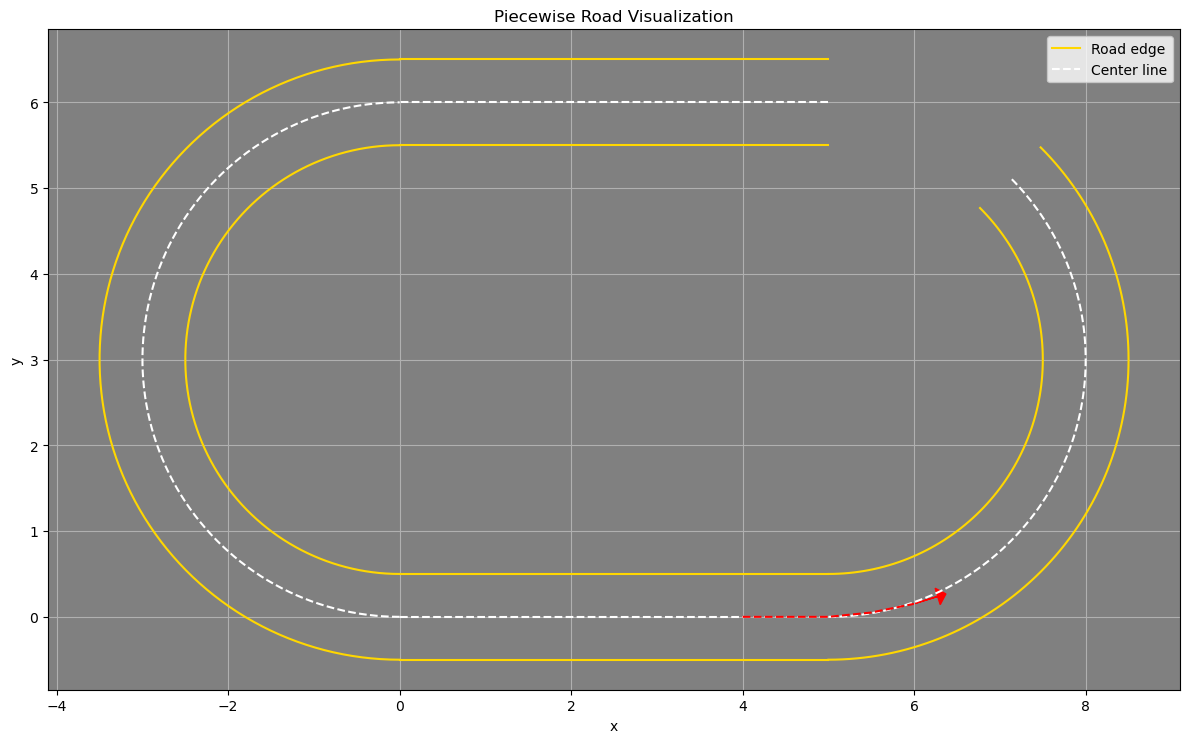

Step number 5, choose action:  .5


 dx=8.29,dy=4.49, direction = 0.50
   Distance: 0.07, Direction: 0.50, carenv.theta: 0.80, difection diff Direction: 0.30, Out of road: False
 


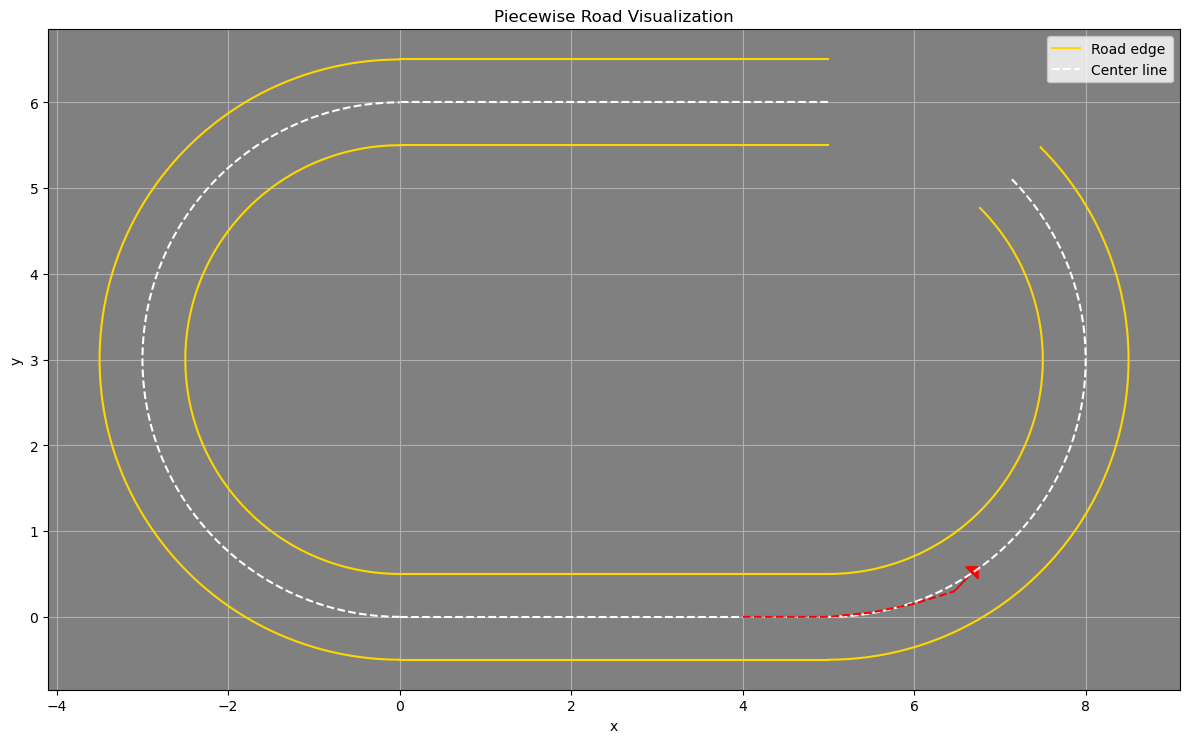

Step number 6, choose action:  .25


 dx=7.45,dy=5.77, direction = 0.66
   Distance: 0.04, Direction: 0.66, carenv.theta: 1.05, difection diff Direction: 0.39, Out of road: False
 


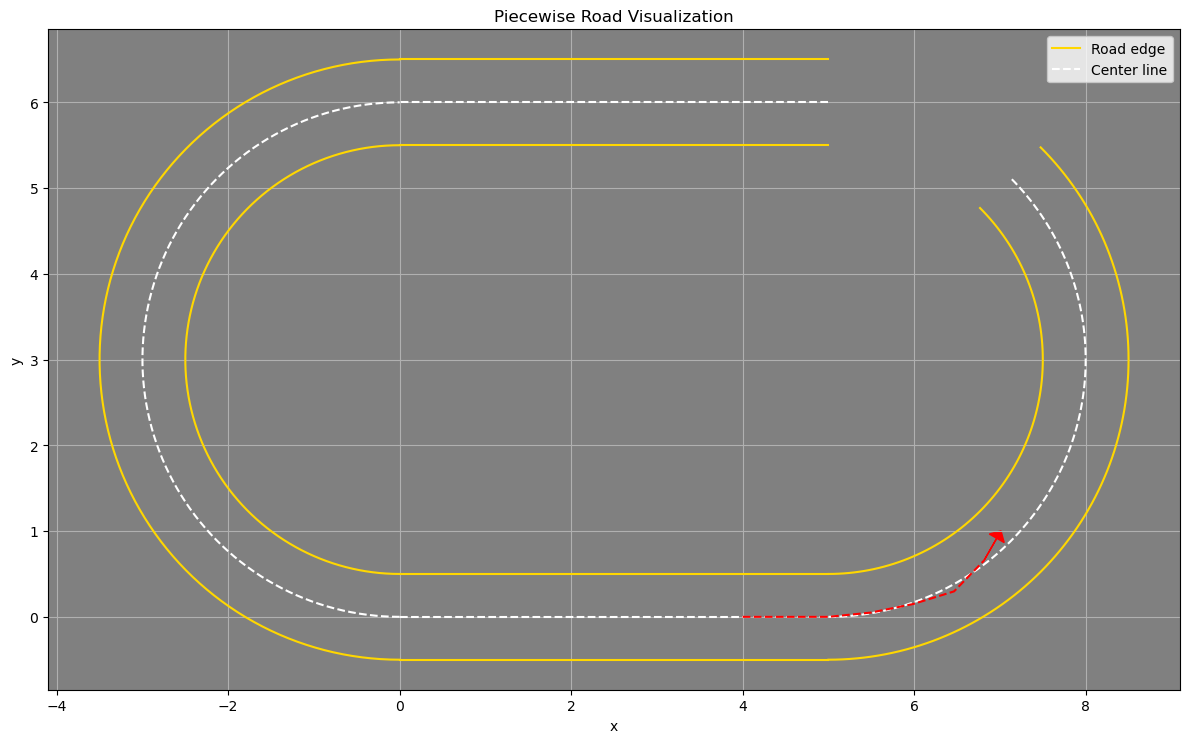

Step number 7, choose action:  .1


 dx=6.41,dy=6.91, direction = 0.82
   Distance: 0.19, Direction: 0.82, carenv.theta: 1.15, difection diff Direction: 0.33, Out of road: False
 


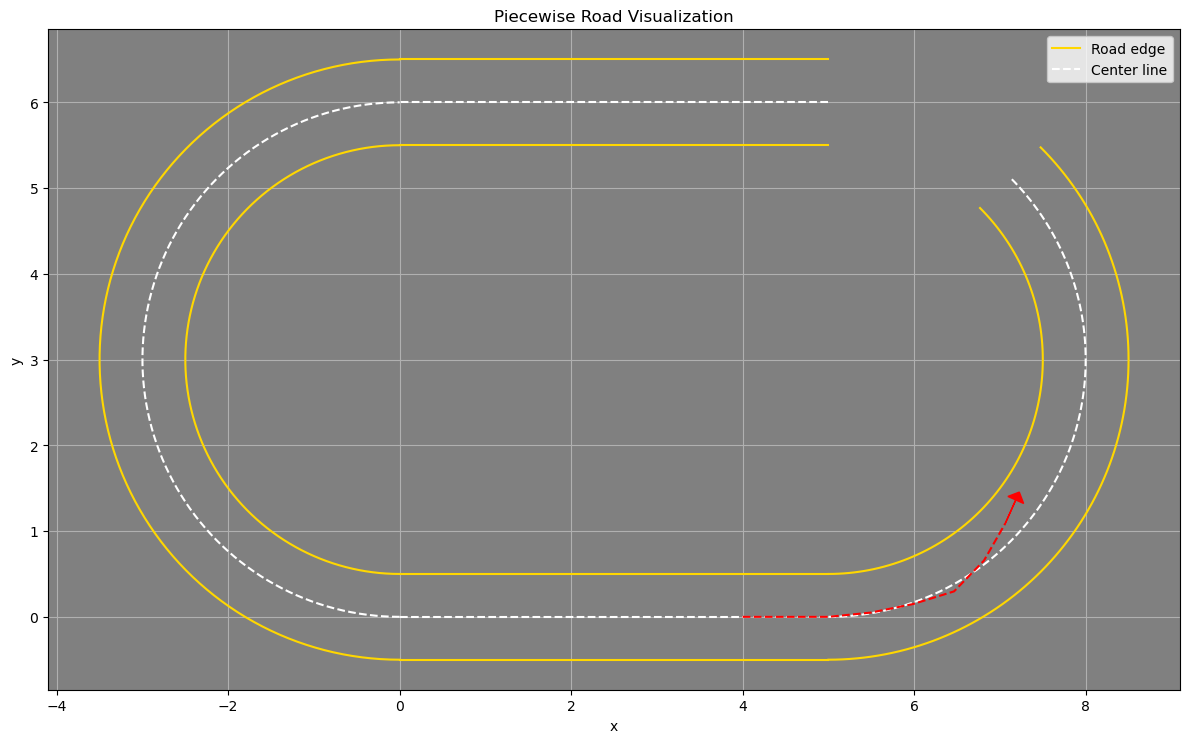

Step number 8, choose action:  0


 dx=5.09,dy=7.93, direction = 1.00
   Distance: 0.31, Direction: 1.00, carenv.theta: 1.15, difection diff Direction: 0.15, Out of road: False
 


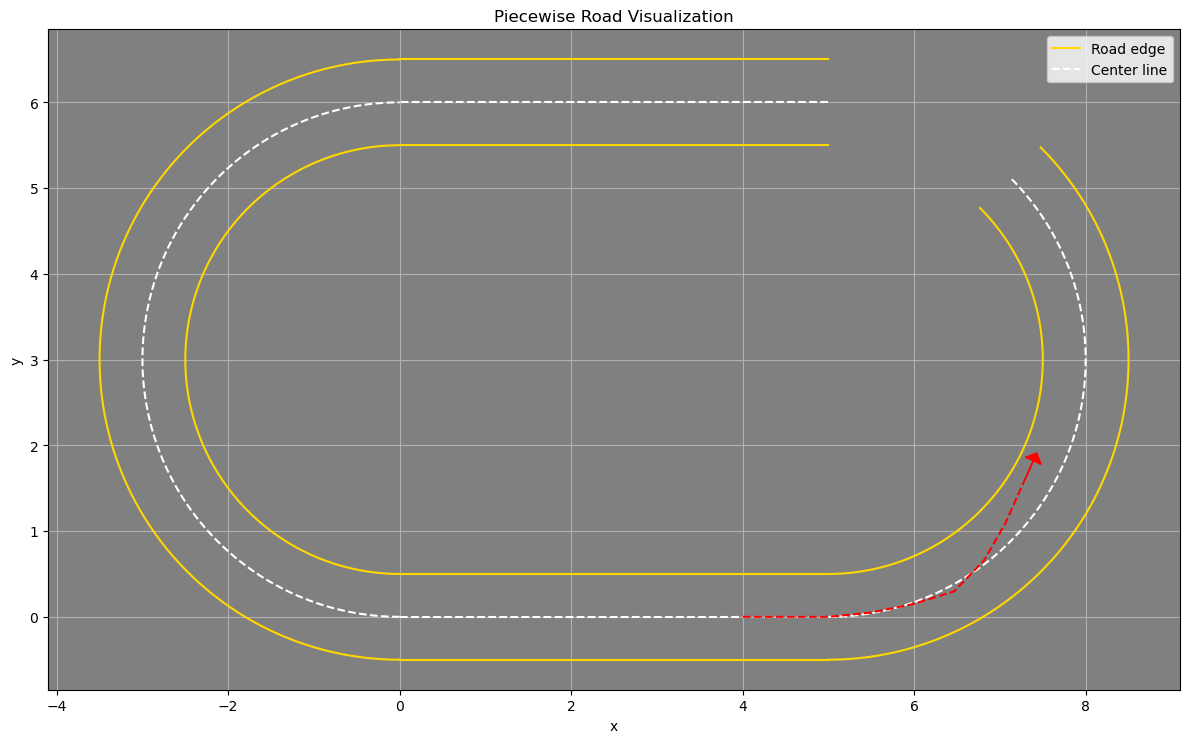

Step number 9, choose action:  0


 dx=3.53,dy=8.74, direction = 1.19
   Distance: 0.34, Direction: 1.19, carenv.theta: 1.15, difection diff Direction: 0.04, Out of road: False
 


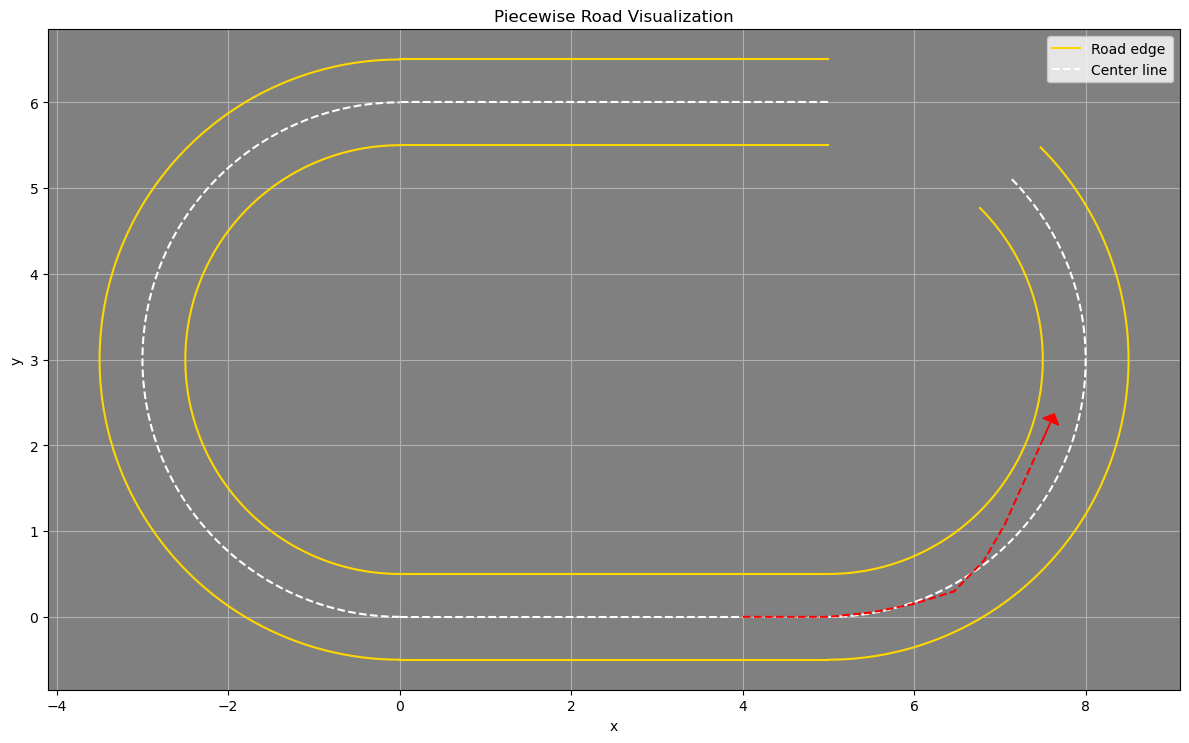

Step number 10, choose action:  0


 dx=1.87,dy=9.24, direction = 1.37
   Distance: 0.27, Direction: 1.37, carenv.theta: 1.15, difection diff Direction: 0.22, Out of road: False
 


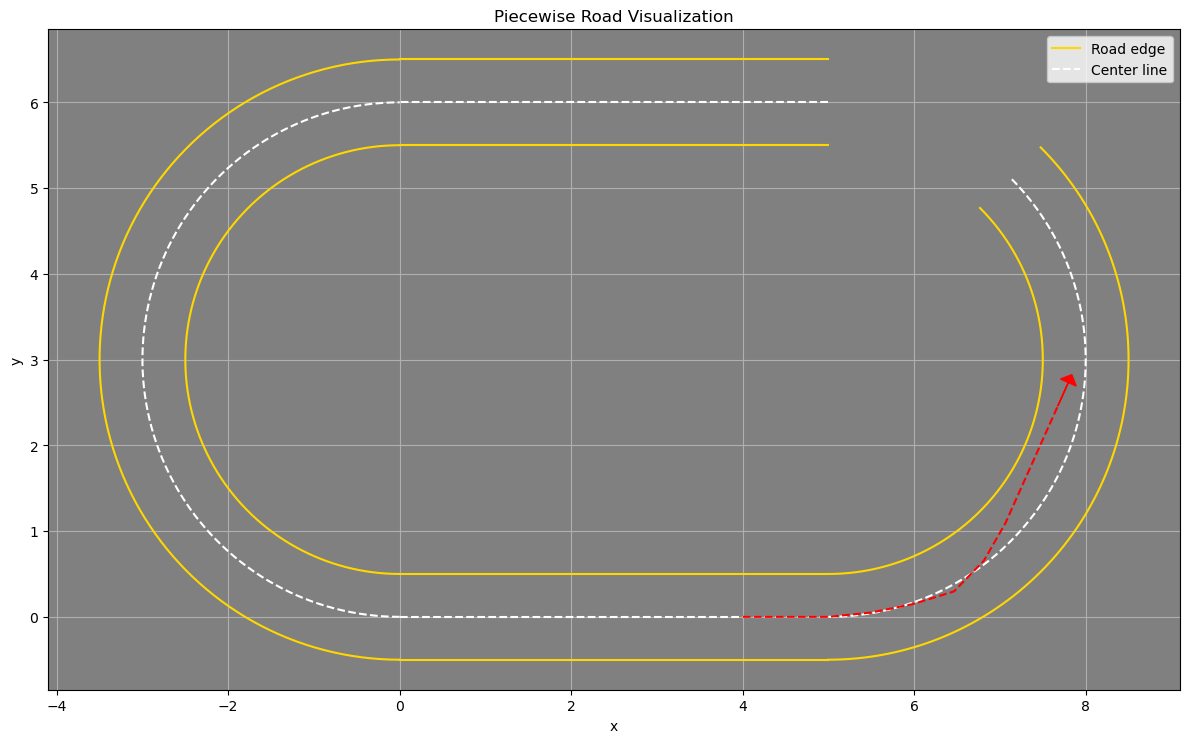

Step number 11, choose action:  0


 dx=0.28,dy=9.42, direction = 1.54
   Distance: 0.12, Direction: 1.54, carenv.theta: 1.15, difection diff Direction: 0.39, Out of road: False
 


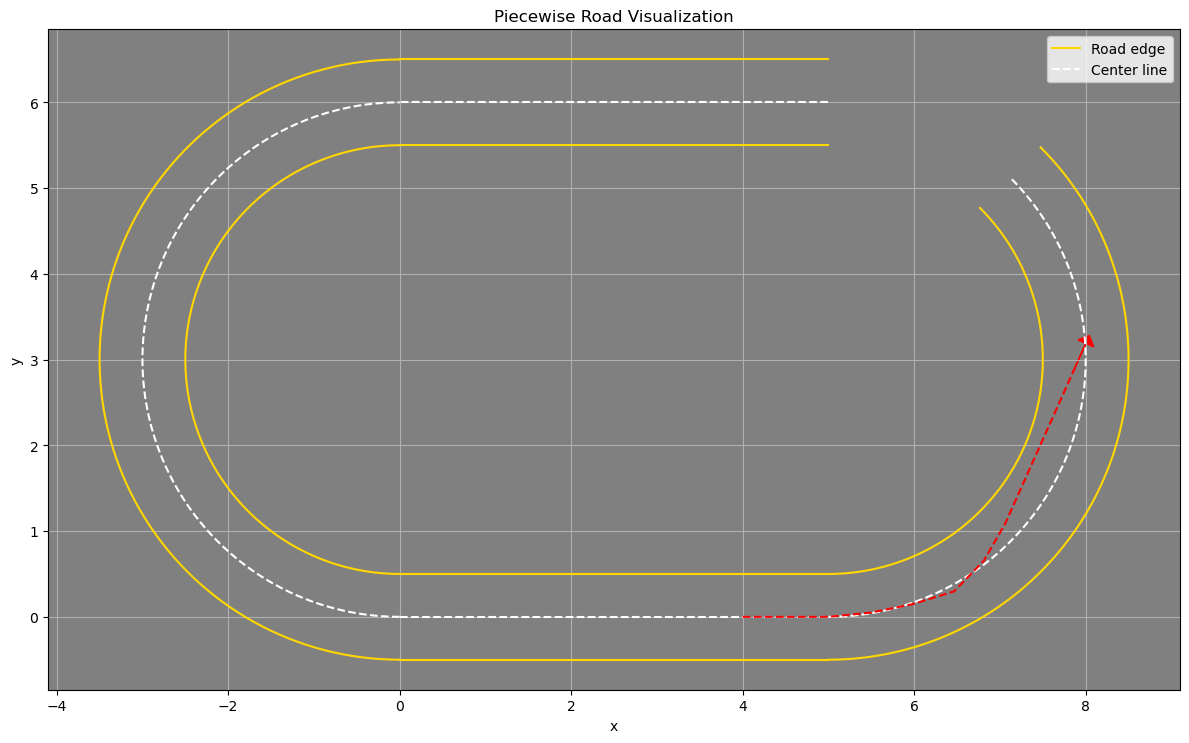

Step number 12, choose action:  2


 dx=-1.13,dy=9.36, direction = 1.69
   Distance: 0.11, Direction: 1.69, carenv.theta: 3.15, difection diff Direction: 1.46, Out of road: False
 


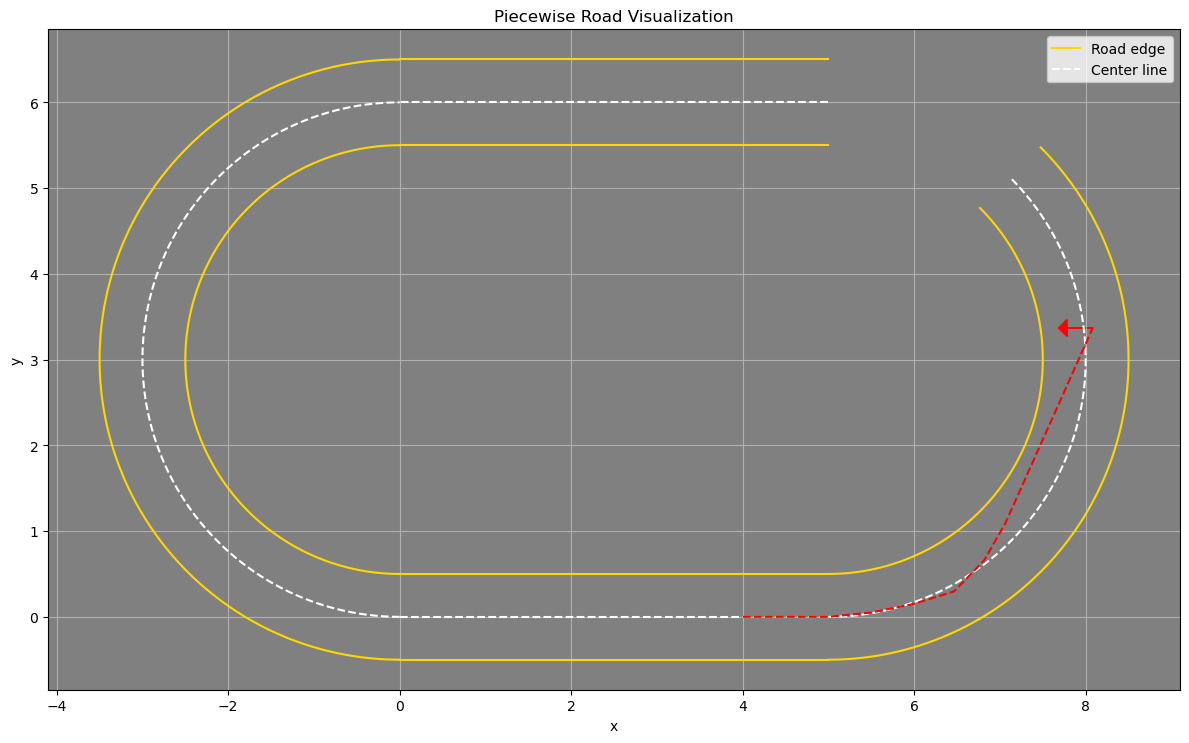

Step number 13, choose action:  -1


 dx=-1.33,dy=9.33, direction = 1.71
   Distance: 0.39, Direction: 1.71, carenv.theta: 2.15, difection diff Direction: 0.44, Out of road: False
 


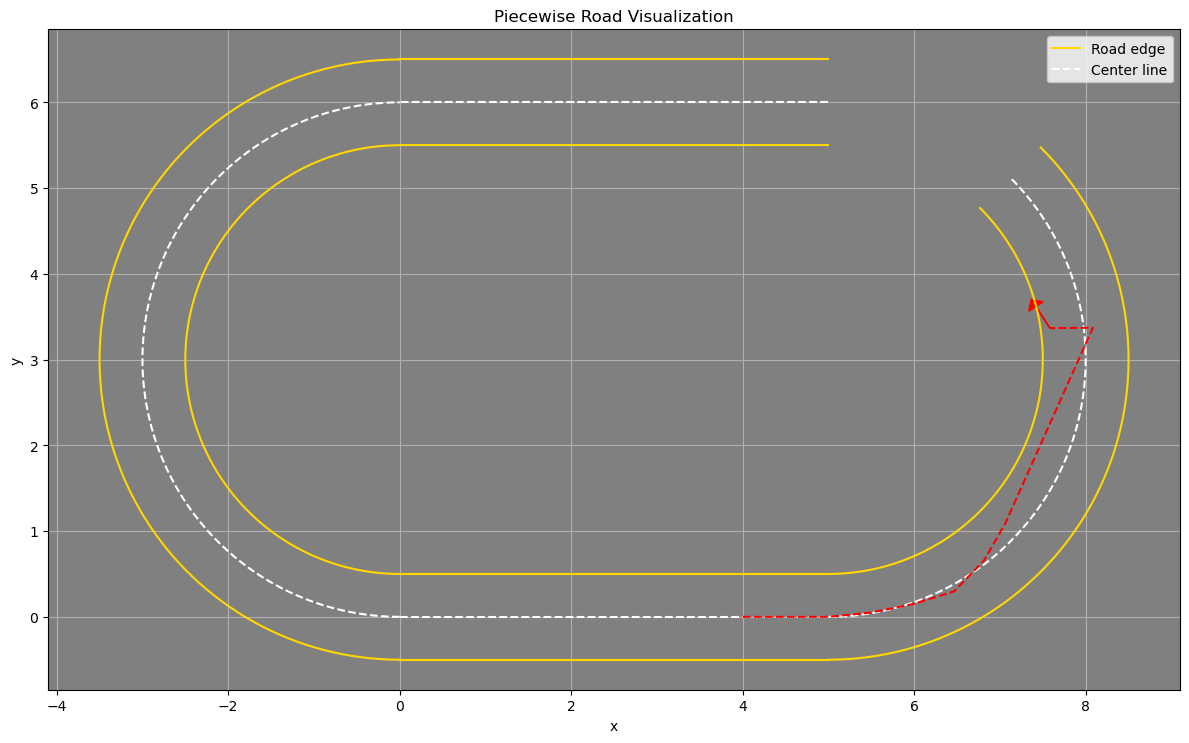

Step number 14, choose action:  0


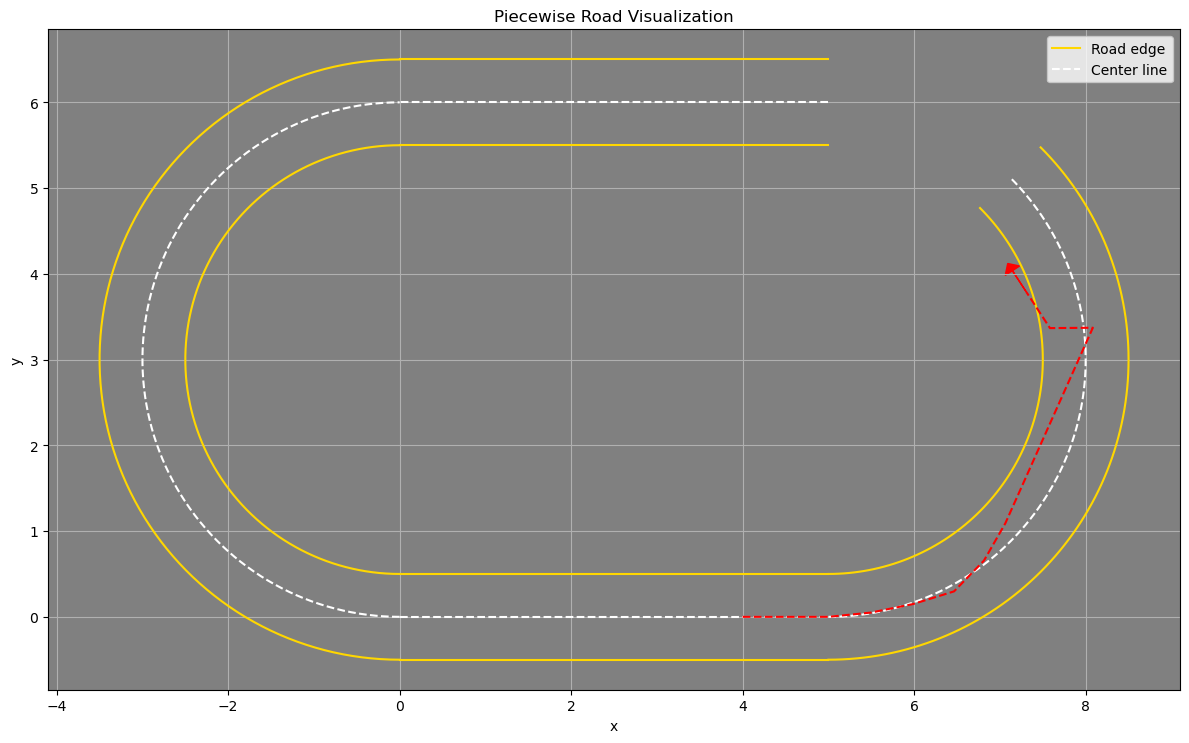

Step number 15, choose action:  0


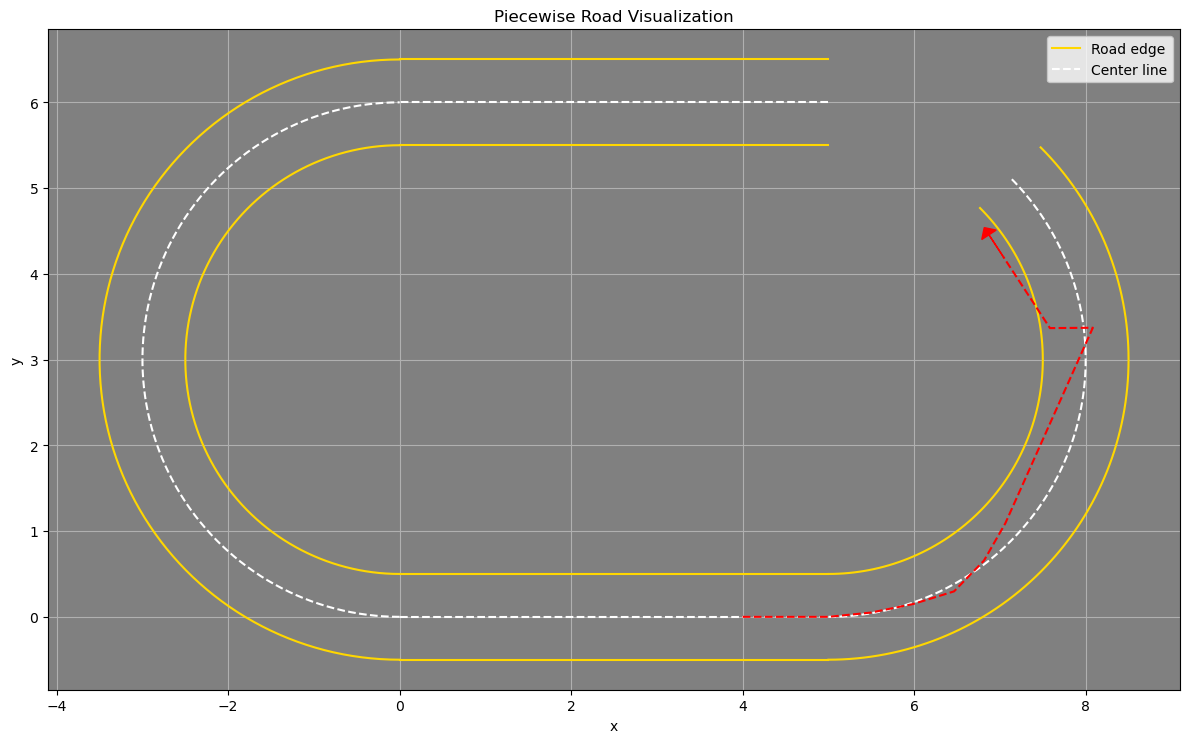

Step number 16, choose action:  0


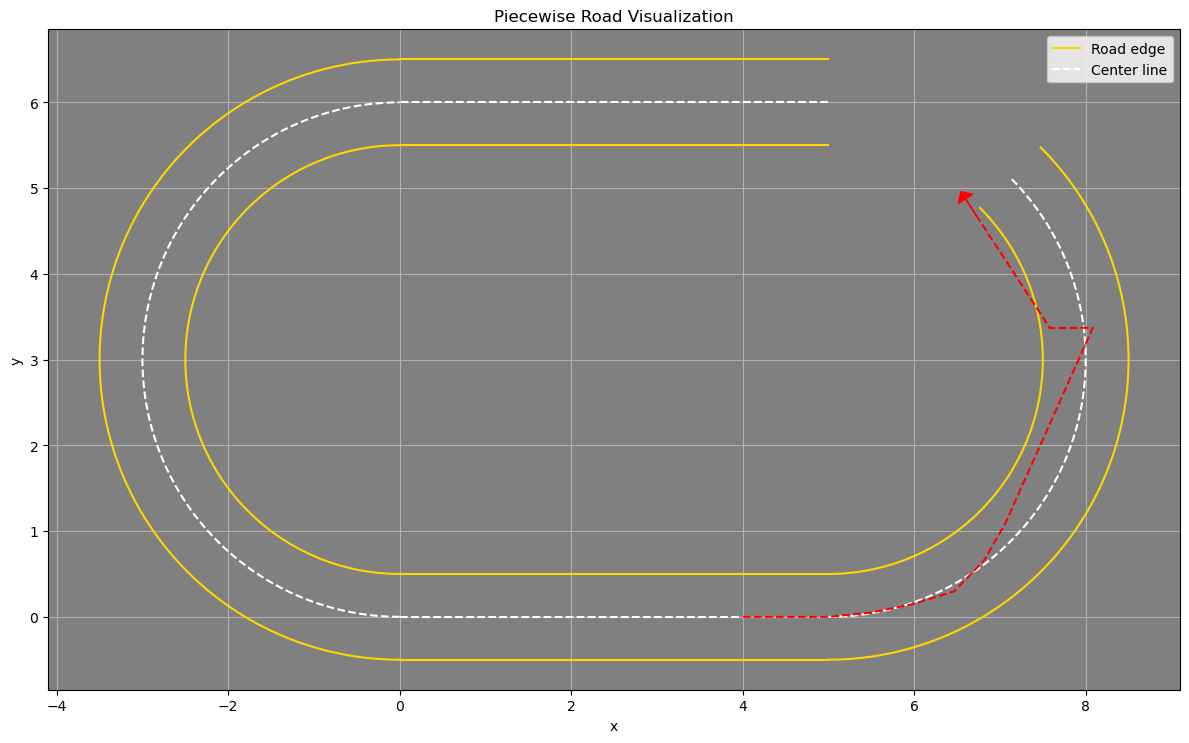

Step number 17, choose action:  0


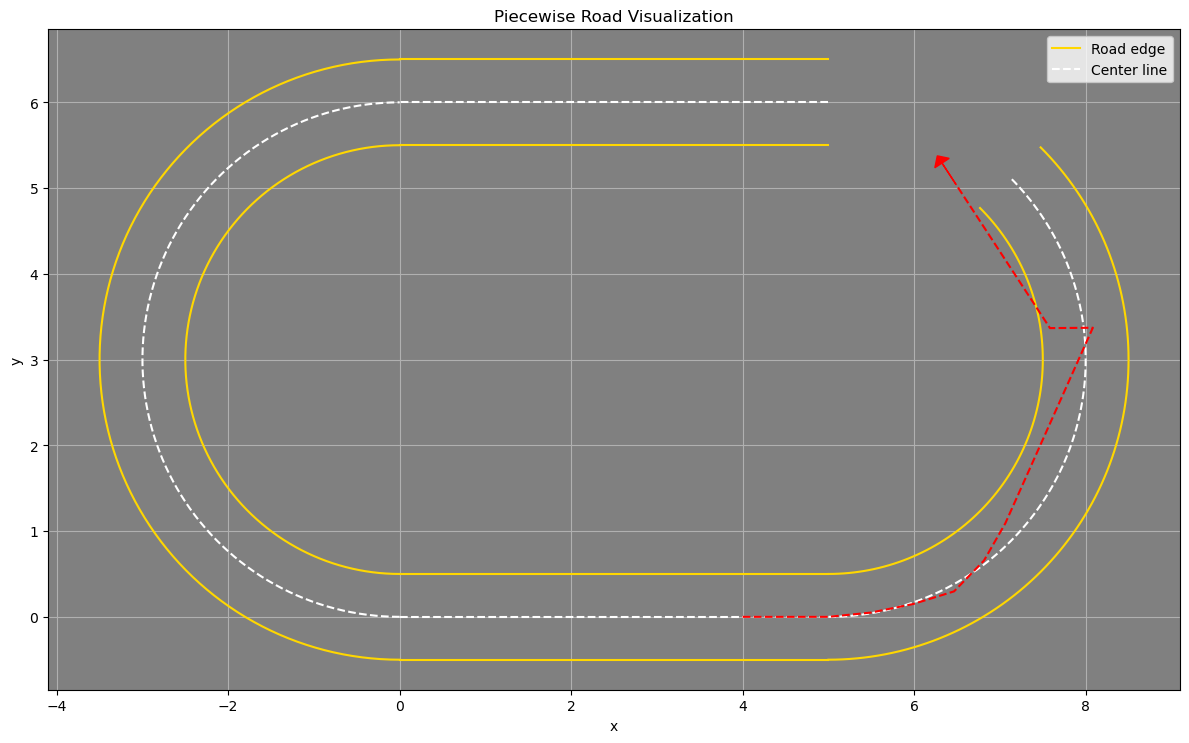

Step number 18, choose action:  0


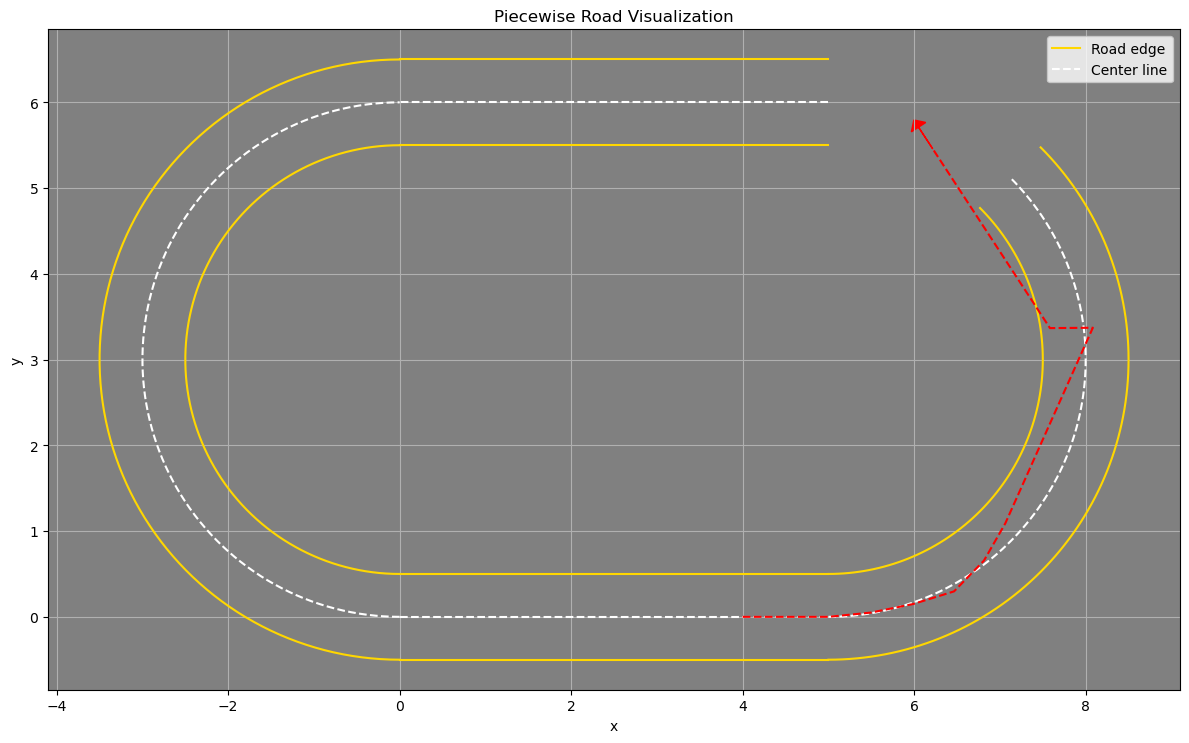

Step number 19, choose action:  .5


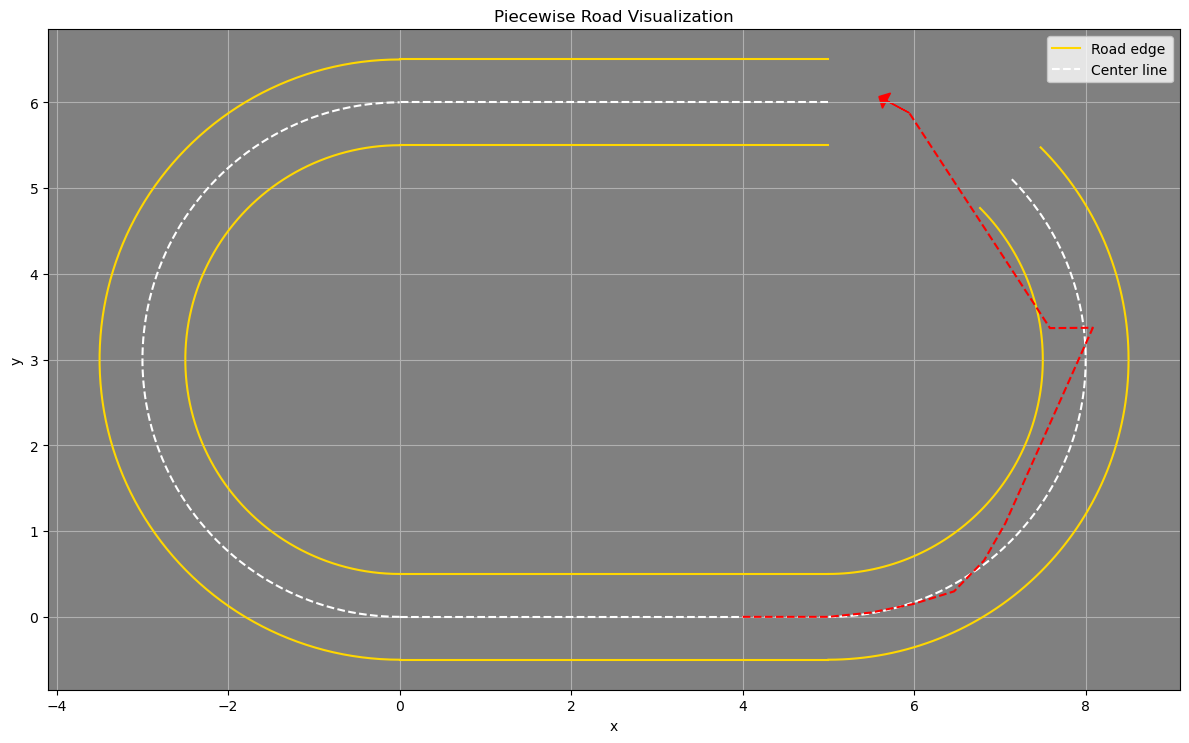

Step number 20, choose action:  .25


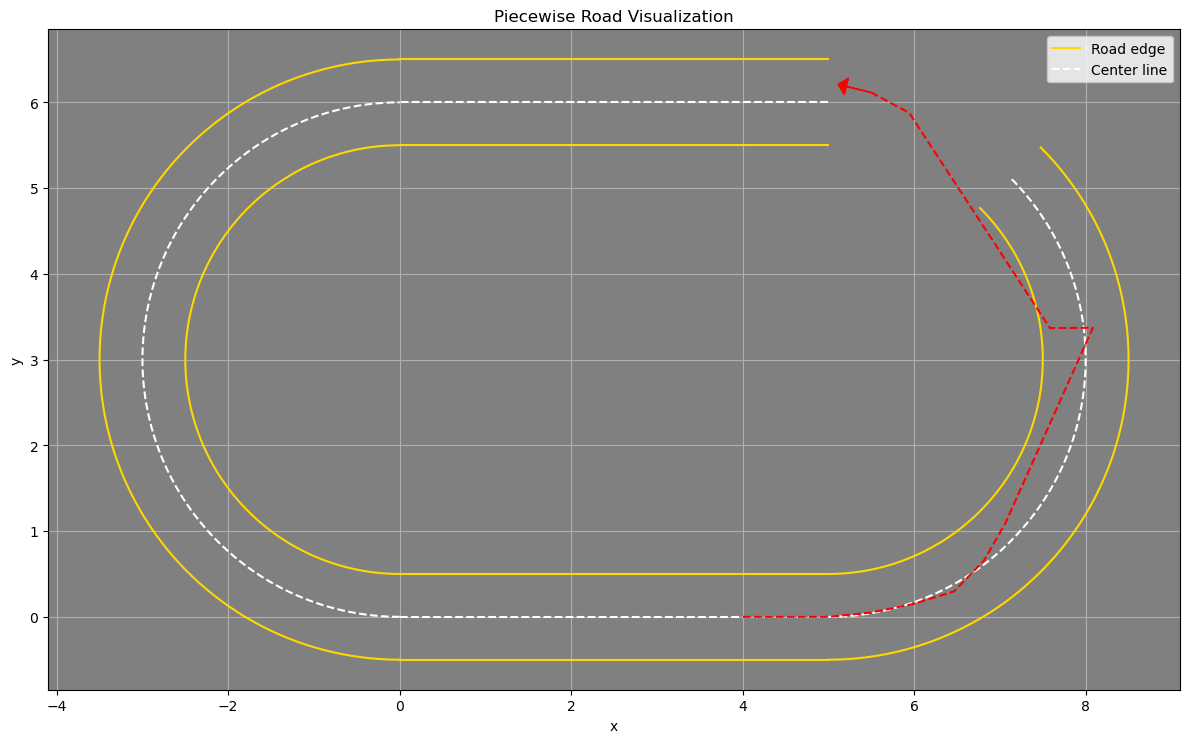

Step number 21, choose action:  .1


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.23, Direction: 3.14, carenv.theta: 3.00, difection diff Direction: 0.14, Out of road: False
 


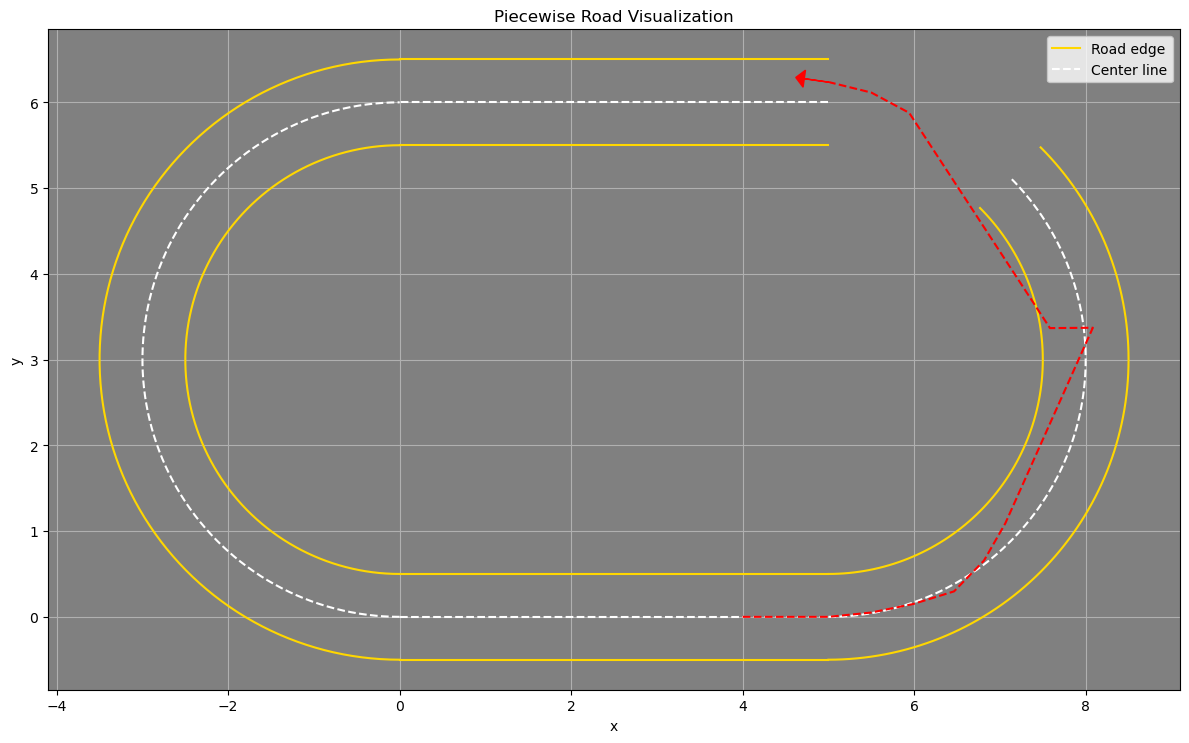

Step number 22, choose action:  .14


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.30, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


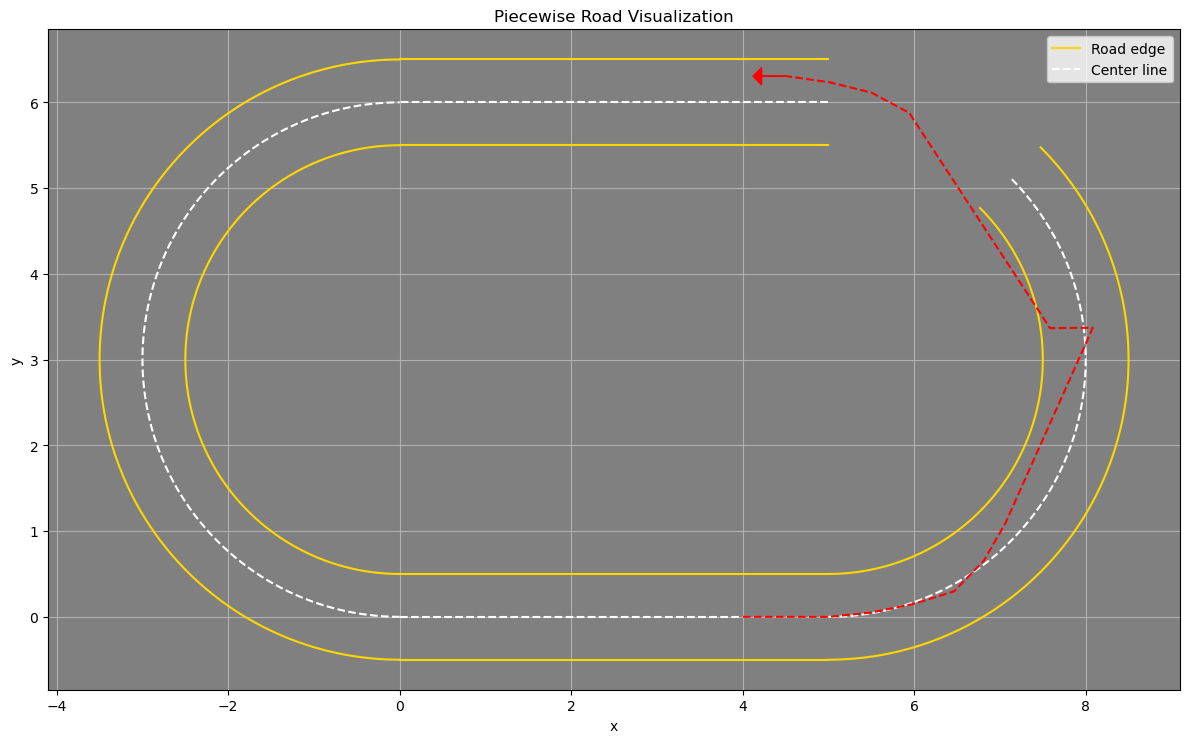

Step number 23, choose action:  0.


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.30, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


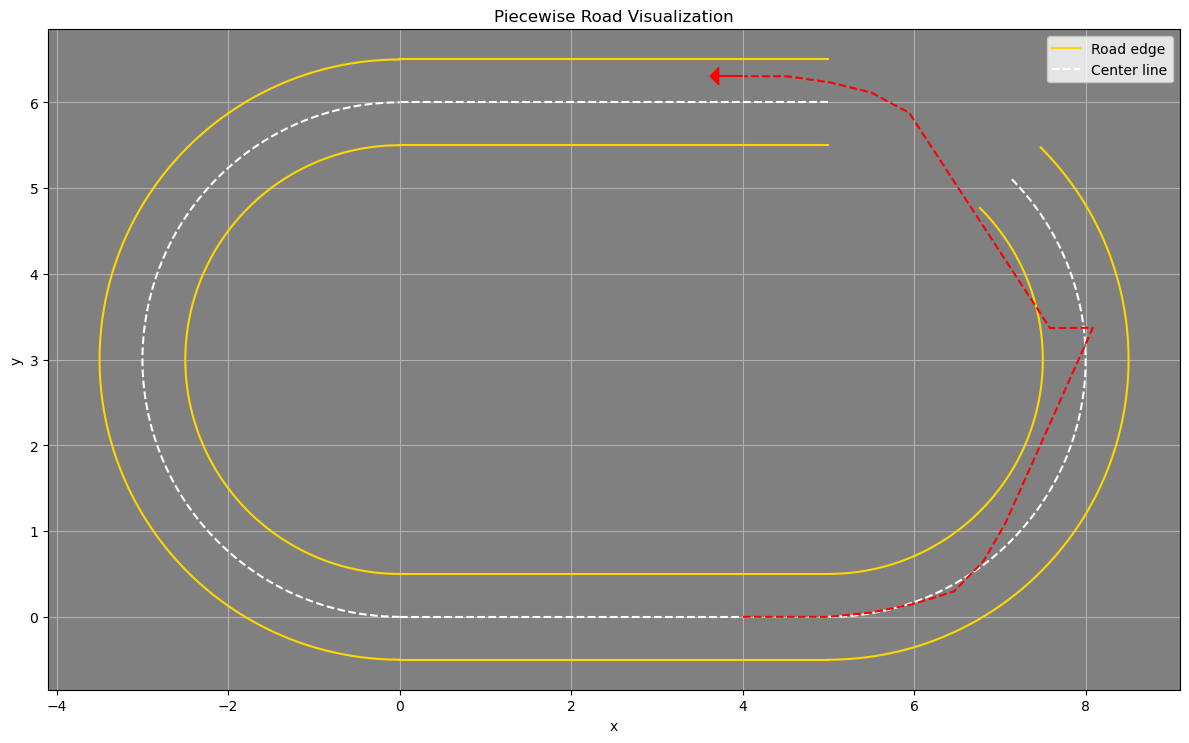

Step number 24, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


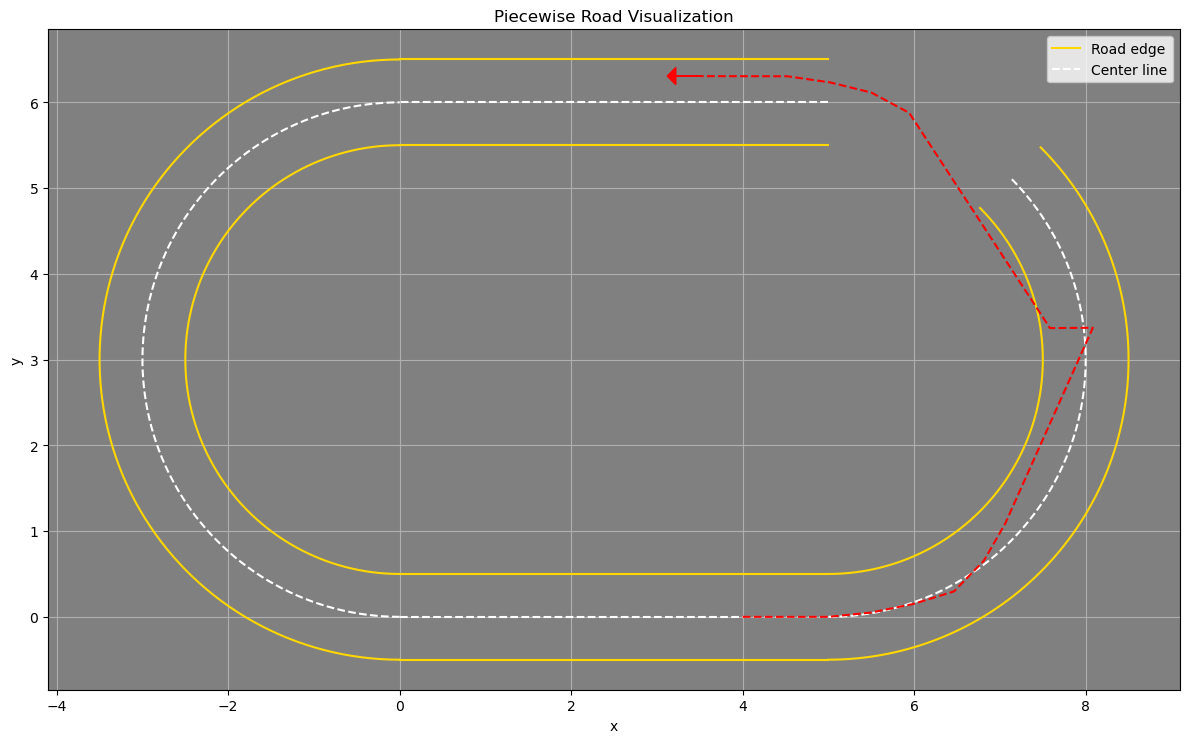

Step number 25, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


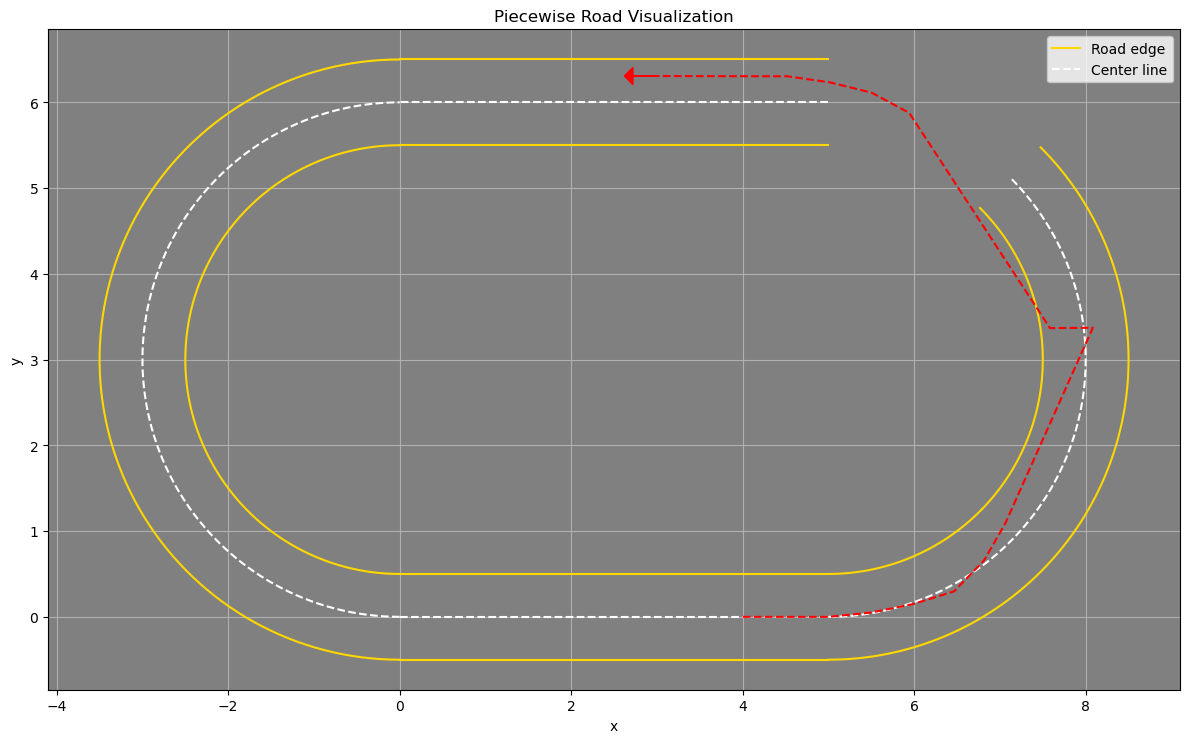

Step number 26, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


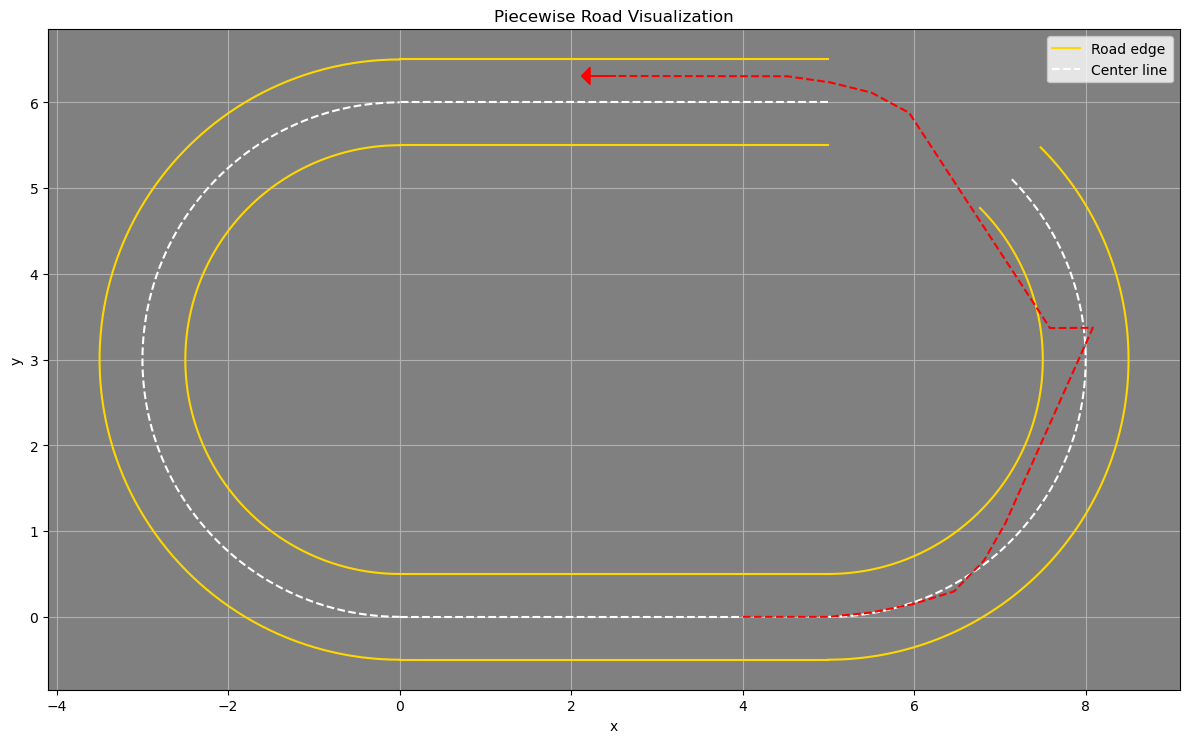

Step number 27, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


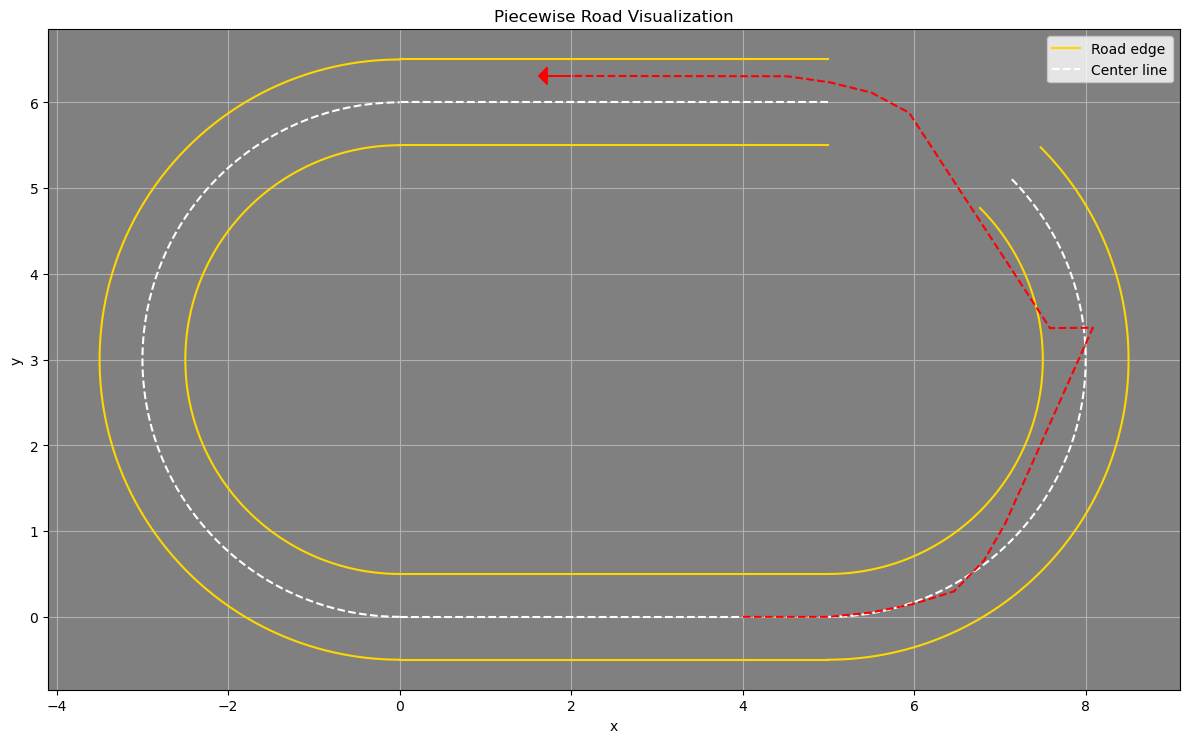

Step number 28, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


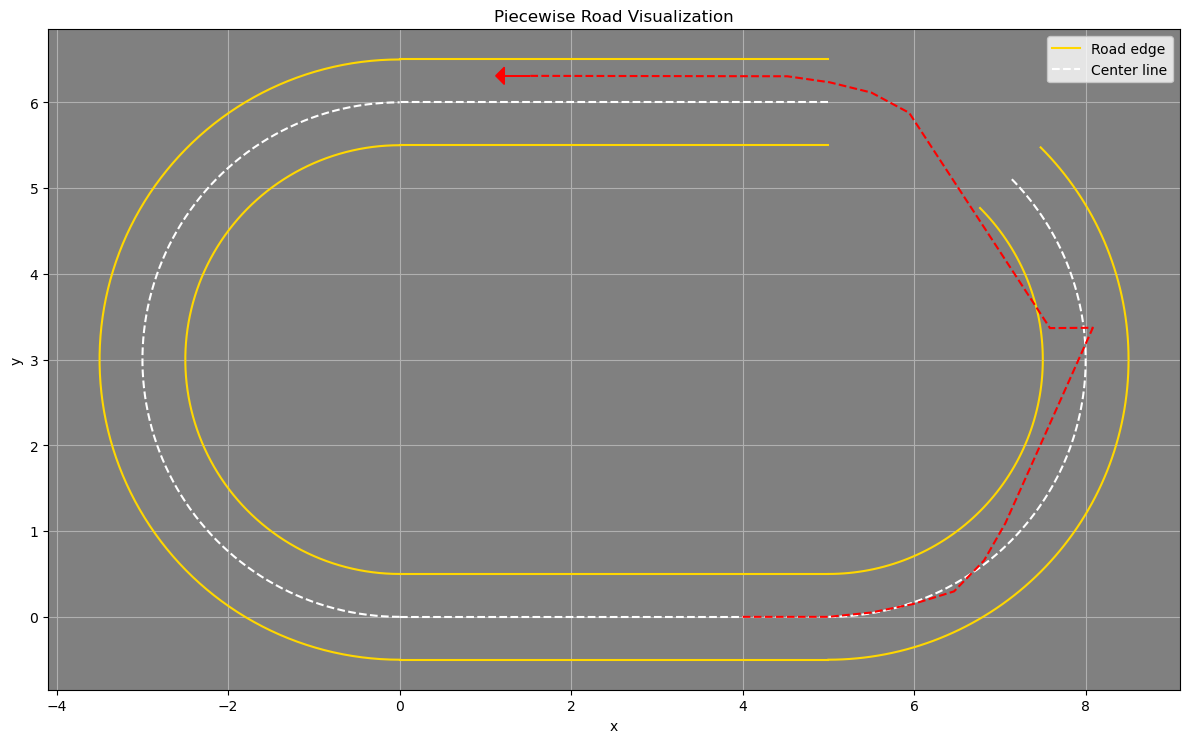

Step number 29, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


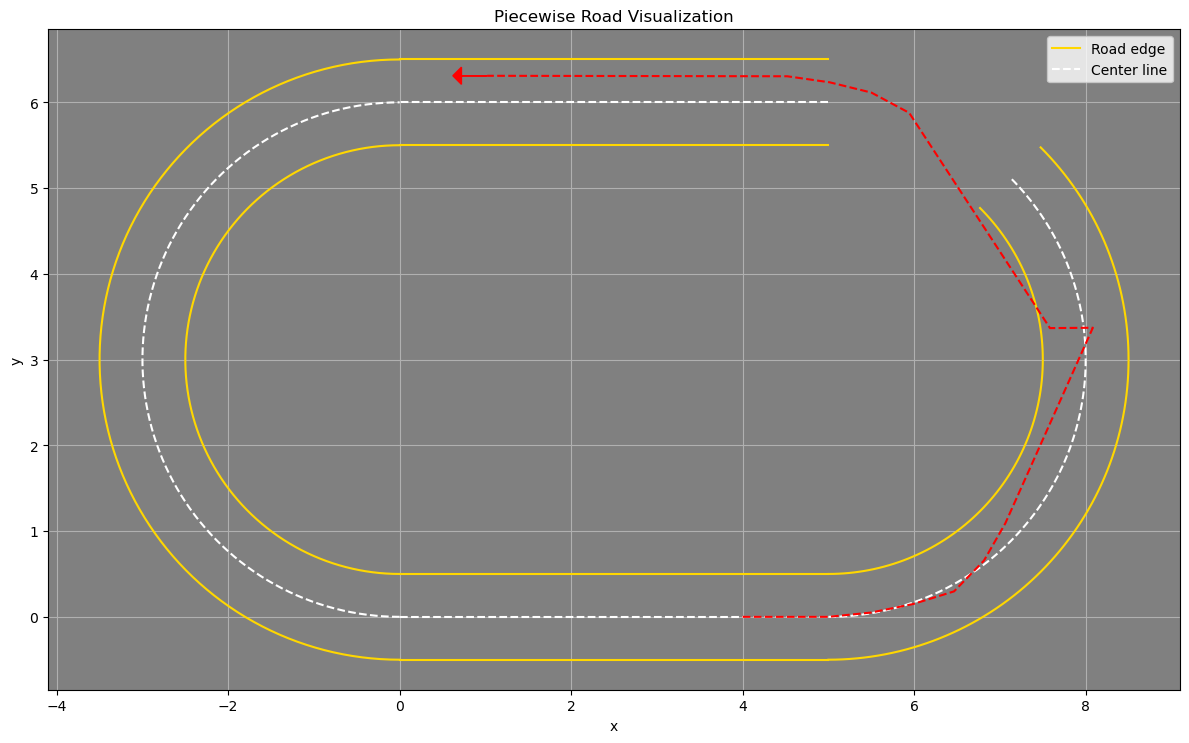

Step number 30, choose action:  0.


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


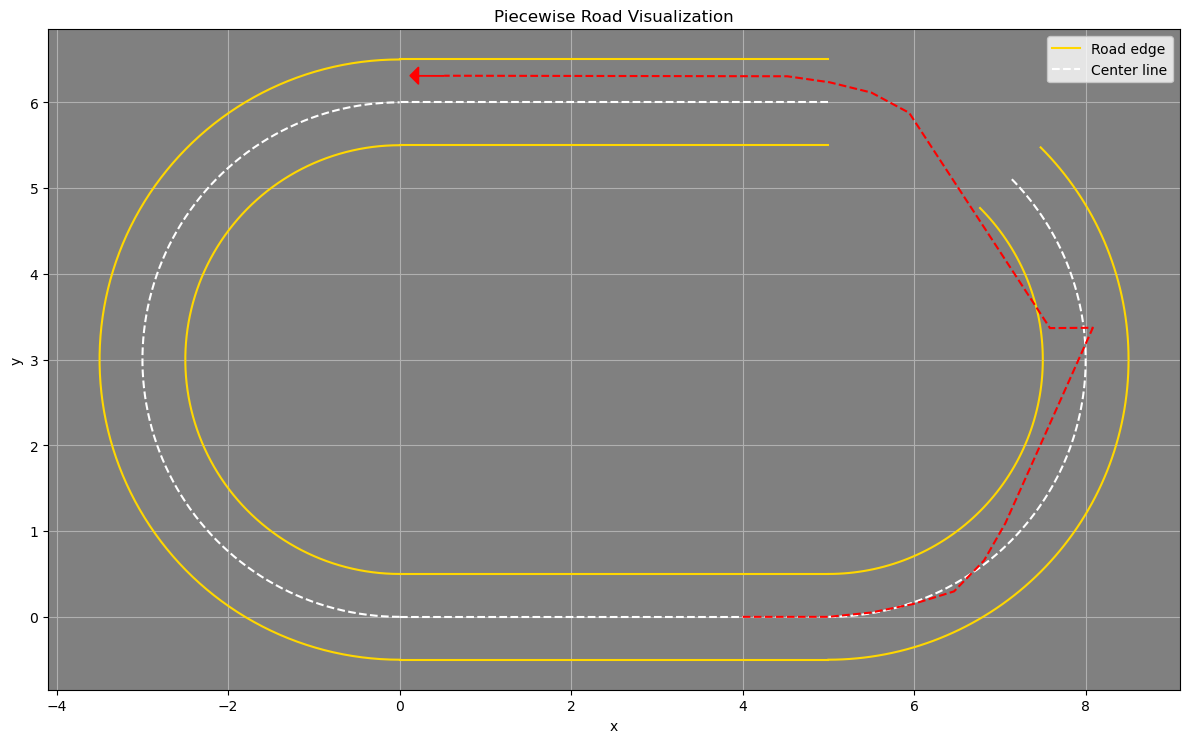

Step number 31, choose action:  0


 dx=-1.00,dy=-0.00, direction = 3.14
   Distance: 0.31, Direction: 3.14, carenv.theta: 3.14, difection diff Direction: 0.00, Out of road: False
 


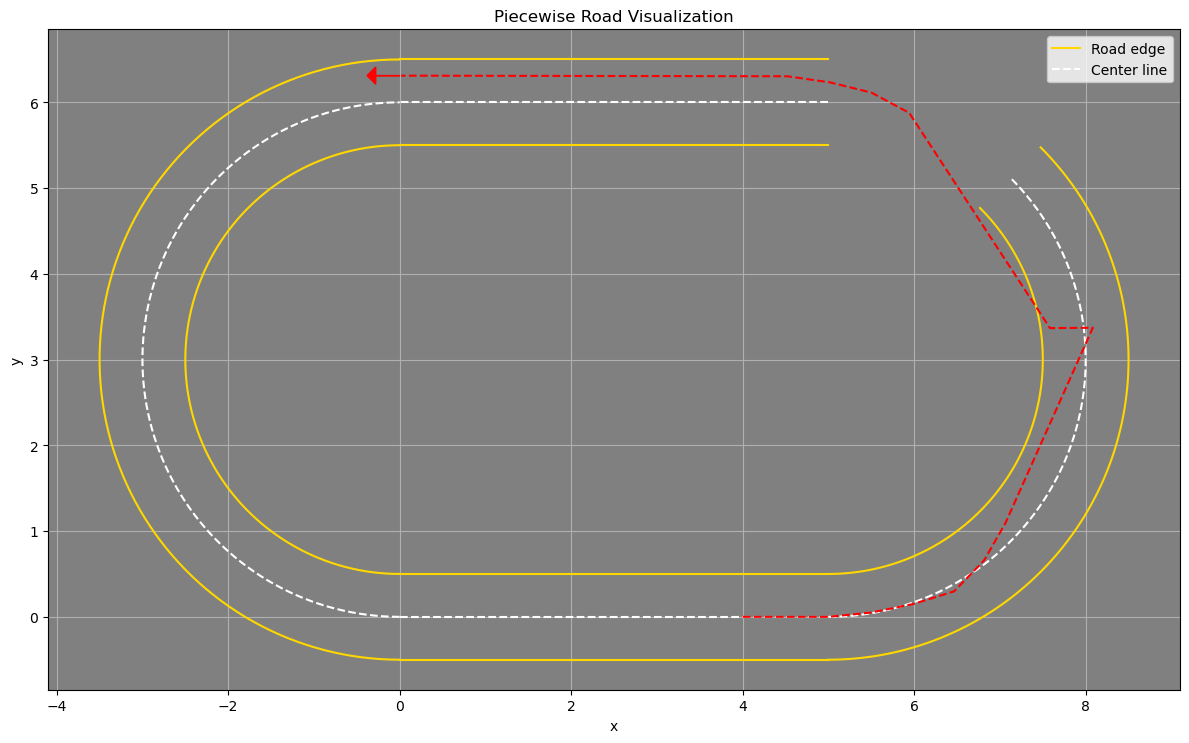

Step number 32, choose action:  0


 dx=9.33,dy=1.35, direction = 0.14
   Distance: 0.35, Direction: 0.14, carenv.theta: 3.14, difection diff Direction: 3.00, Out of road: False
 


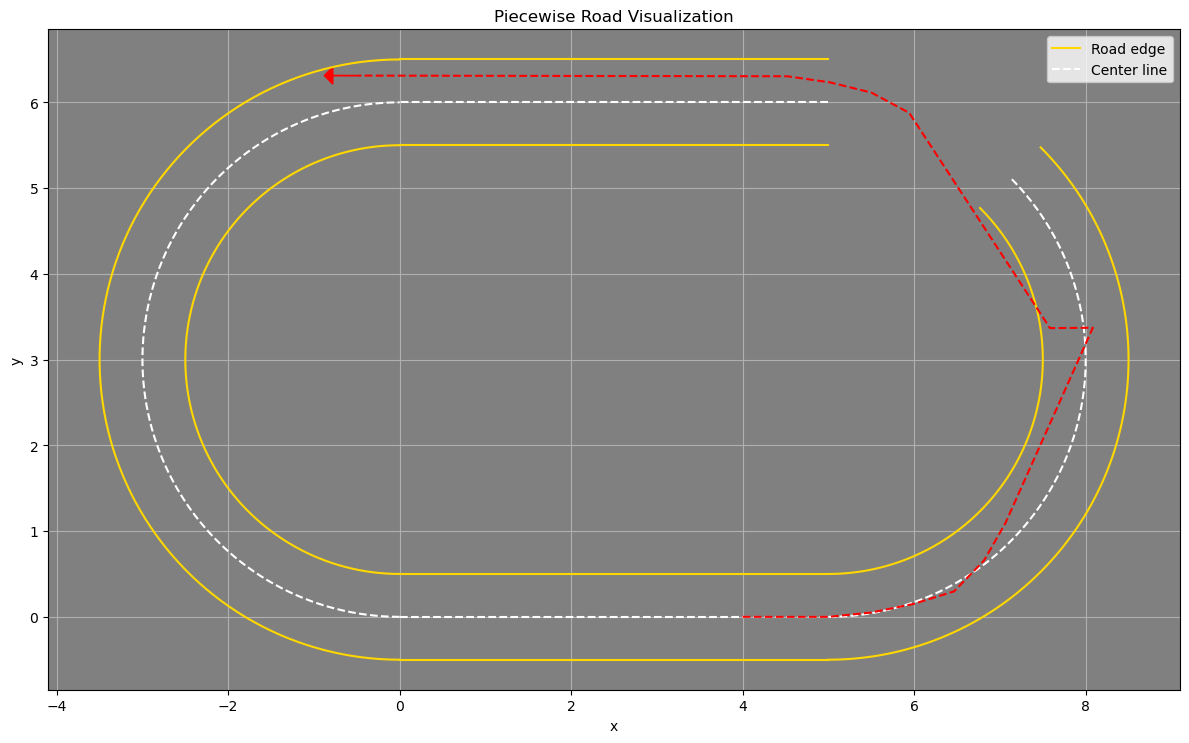

Step number 33, choose action:  .5


 dx=9.04,dy=2.67, direction = 0.29
   Distance: 0.45, Direction: 0.29, carenv.theta: 3.64, difection diff Direction: 3.35, Out of road: False
 


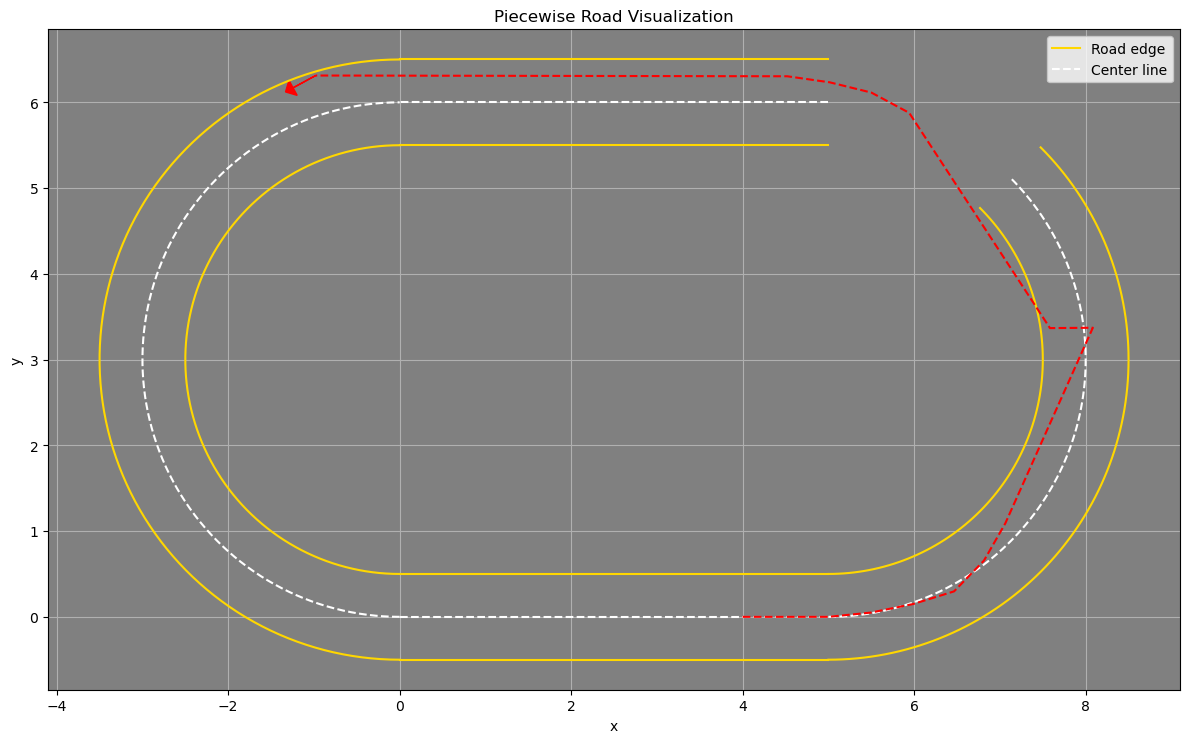

In [ ]:
import math
import sympy as sp
from sympy import N
import numpy as np
from scipy.optimize import minimize_scalar

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class Settings:
    def __init__(self):
        # road settings
        self.road_segments = [
            {
                'x': lambda t: t,
                'y': lambda t: 0.000001*t,
                't_start': 0,
                't_end': 5
            },
            {
                'x': lambda t: 5 + 3 * sp.sin(np.pi * (t - 5)),
                'y': lambda t: 3-3 * sp.cos(np.pi * (t - 5)),
                't_start': 5,
                't_end': 5.75
            },
            {
                'x': lambda t: 5 - (t - 6),
                'y': lambda t: 6-0.000001*t,
                't_start': 6,
                't_end': 11
            },
            {
                'x': lambda t: 3 * sp.sin(np.pi * (t - 10)),
                'y': lambda t: 3 + 3 * sp.cos(np.pi * (t - 10)),
                't_start': 11,
                't_end': 12
            }
        ]
        self.road_width    = 1
        self.road_length   = 15
        self.closed        = False
        self.road_resulotion = 100


        # car settings

        # car initail position
        self.init_car_x = 4
        self.init_car_y = 0
        self.init_car_theta = 0
        self.init_car_speed = .5


class RoadEnv:
    def __init__(self, settings):
        self.settings = settings
        self.t = sp.Symbol('t')

    def get_road_limits(self):
        road_limits = {'left': [], 'right': [], 'center': []}

        for segment in self.settings.road_segments:
            x = segment['x'](self.t)
            y = segment['y'](self.t)

            # Calculate the derivatives of the parametric equations
            dx_dt = sp.diff(x, self.t)
            dy_dt = sp.diff(y, self.t)

            # Calculate the normal vector
            normal_x = -dy_dt / sp.sqrt(dx_dt ** 2 + dy_dt ** 2)
            normal_y =  dx_dt / sp.sqrt(dx_dt ** 2 + dy_dt ** 2)

            # Calculate the road limits
            half_width = self.settings.road_width / 2
            left_x = x + normal_x * half_width
            left_y = y + normal_y * half_width
            right_x = x - normal_x * half_width
            right_y = y - normal_y * half_width

            # Create vectorized lambda functions for the road limits
            left_func   = sp.lambdify(self.t, [left_x, left_y], 'numpy')
            right_func  = sp.lambdify(self.t, [right_x, right_y], 'numpy')
            center_func = sp.lambdify(self.t, [x, y], 'numpy')

            road_limits['left'].append(left_func)
            road_limits['right'].append(right_func)
            road_limits['center'].append(center_func)

        return road_limits

    def distance_road_center(self, x, y):
        min_distance = float('inf')
        closest_segment = None
        closest_t = None

        for i, segment in enumerate(self.settings.road_segments):
            road_center_x = sp.lambdify(self.t, sp.sympify(segment['x'](self.t)), 'numpy')
            road_center_y = sp.lambdify(self.t, sp.sympify(segment['y'](self.t)), 'numpy')

            def distance_func(t):
                return (road_center_x(t) - x) ** 2 + (road_center_y(t) - y) ** 2

            result = minimize_scalar(distance_func, bounds=(segment['t_start'], segment['t_end']), method='bounded')
            distance = np.sqrt(result.fun)

            if distance < min_distance:
                min_distance = distance
                closest_segment = i
                closest_t = result.x

        return min_distance, closest_segment, closest_t

    def road_direction_and_terminal(self, distance, segment, t):
        if distance > self.settings.road_width / 2:
            return None, None, True

        # Calculate the direction of the road at the closest point
        segment = self.settings.road_segments[segment]
        x_func = sp.lambdify(self.t, segment['x'](self.t), 'numpy')
        y_func = sp.lambdify(self.t, segment['y'](self.t), 'numpy')

        dx_dt = sp.diff(segment['x'](self.t), self.t)
        dy_dt = sp.diff(segment['y'](self.t), self.t)
        
        dx_func = sp.lambdify(self.t, dx_dt, 'numpy')
        dy_func = sp.lambdify(self.t, dy_dt, 'numpy')

        dx = dx_func(t)
        dy = dy_func(t)
        
        direction = np.pi/2-np.arctan2(dx,dy)
        print(f' dx={dx:.2f},dy={dy:.2f}, direction = {direction:.2f}')
        return distance, np.where(direction < 0, direction + 2 * np.pi, direction), False

class CarEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def car_reset():
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def move(self, steering_angle):
        # Update the car position
        self.x += self.speed * np.cos(self.theta)
        self.y += self.speed * np.sin(self.theta)
        self.theta = (self.theta +steering_angle) % (2 * np.pi)
        self.trejectory.append((self.x, self.y))
        
        


def Visualize(roadenv, carenv, settings):
    road_limits = roadenv.get_road_limits()

    fig, ax = plt.subplots(figsize=(12, 12))

    for i, segment in enumerate(settings.road_segments):
        t = np.linspace(segment['t_start'], segment['t_end'], settings.road_resulotion)

        left_x, left_y = road_limits['left'][i](t)
        right_x, right_y = road_limits['right'][i](t)
        center_x, center_y = road_limits['center'][i](t)

        ax.plot(left_x, left_y, '-', color='gold')
        ax.plot(right_x, right_y, '-', color='gold')
        ax.plot(center_x, center_y, 'w--')

    ax.plot([], [], '-', color='gold', label='Road edge')
    ax.plot([], [], 'w--', label='Center line')

    ax.set_facecolor('gray')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Piecewise Road Visualization')
    ax.legend()

    # Ensure the aspect ratio is equal
    ax.set_aspect('equal', 'box')

    # Plot the car as an arrow and the trajectory in red
    arrow_length = 0.3
    ax.arrow(carenv.x, carenv.y, arrow_length*np.cos(carenv.theta), arrow_length*np.sin(carenv.theta),
             head_width=0.2, head_length=0.1, fc='r', ec='r', label='Car')
    ax.plot(*zip(*carenv.trejectory), 'r--', label='Trajectory')

    ax.grid(True)
    plt.tight_layout()
    plt.show()




settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(50):
    action = input(f"Step number {i+1}, choose action: ")
    if action == 'q':
        break
    carenv.move(float(action))
    distance, closest_segment, closest_t = roadenv.distance_road_center(carenv.x, carenv.y)
    distance, direction, out_of_road = roadenv.road_direction_and_terminal(distance, closest_segment, closest_t)
    if not  out_of_road:
        #round the direction to 2 decimal points
        print(f"   Distance: {distance:.2f}, Direction: {direction:.2f}, carenv.theta: {carenv.theta:.2f}, difection diff Direction: {abs(direction - carenv.theta):.2f}, Out of road: {out_of_road}")
        print(f" ")
    if i>2:
        plt.close('all')
        





    Visualize(roadenv, carenv, settings)

Distance: 0.17887588310957045,road_direction =1.9983974876916475, Direction: 1.1068280097679846, carenv.theta: 6.1899676781075215, Out of road: False
                    , Direction: 5.083139668339537
Distance: 0.36526296051954116,road_direction =1.9947311524101083, Direction: 1.106092723117805, carenv.theta: 0.32115481451758754, Out of road: False
                    , Direction: 0.7849379086002175


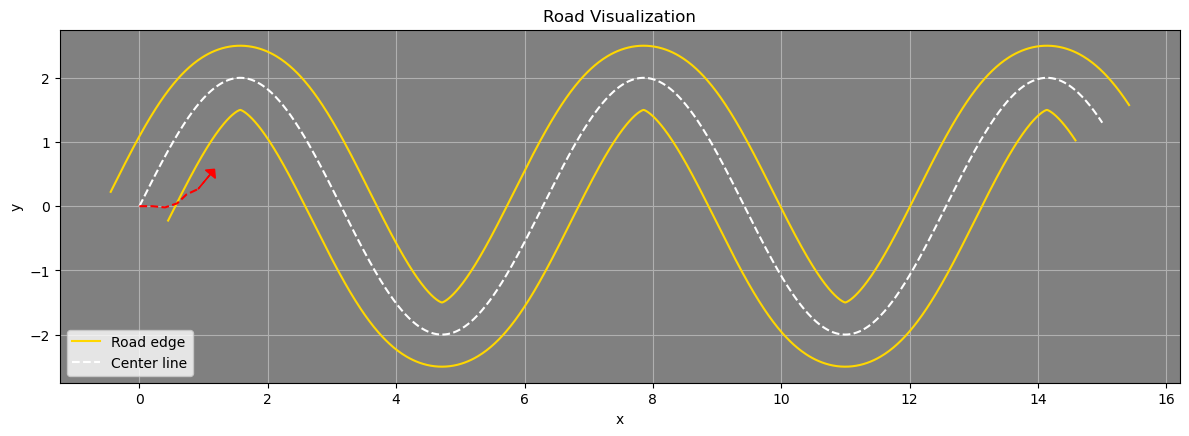

In [62]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(5):
    carenv.move(np.random.uniform(-.5, .5))
    distance, closest_x = roadenv.distance_road_center(carenv.x, carenv.y)
    distance,road_direction, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_x)
    if not  out_of_road:
        print(f"Distance: {distance},road_direction ={road_direction}, Direction: {direction}, carenv.theta: {carenv.theta}, Out of road: {out_of_road}")
        print(f"                    , Direction: {abs(direction - carenv.theta)}")



Visualize(roadenv, carenv, settings)

In [1]:
import numpy as np

dire = np.linspace(0,2*np.pi,20)

for i in dire:
    dx = np.cos(i)
    dy = np.sin(i)
    direction = np.pi/2-np.arctan2(dx,dy)
    # if direction<0

    print(f' dx ={dx:.2f}, dy={dy:.2f},ang = {direction}, ang2 ={np.where(direction < 0, direction + 2 * np.pi, direction)}')

 dx =1.00, dy=0.00,ang = 0.0, ang2 =0.0
 dx =0.95, dy=0.32,ang = 0.3306939635357675, ang2 =0.3306939635357675
 dx =0.79, dy=0.61,ang = 0.6613879270715354, ang2 =0.6613879270715354
 dx =0.55, dy=0.84,ang = 0.992081890607303, ang2 =0.992081890607303
 dx =0.25, dy=0.97,ang = 1.3227758541430708, ang2 =1.3227758541430708
 dx =-0.08, dy=1.00,ang = 1.6534698176788385, ang2 =1.6534698176788385
 dx =-0.40, dy=0.92,ang = 1.984163781214606, ang2 =1.984163781214606
 dx =-0.68, dy=0.74,ang = 2.3148577447503738, ang2 =2.3148577447503738
 dx =-0.88, dy=0.48,ang = 2.6455517082861415, ang2 =2.6455517082861415
 dx =-0.99, dy=0.16,ang = 2.9762456718219092, ang2 =2.9762456718219092
 dx =-0.99, dy=-0.16,ang = 3.306939635357677, ang2 =3.306939635357677
 dx =-0.88, dy=-0.48,ang = 3.6376335988934447, ang2 =3.6376335988934447
 dx =-0.68, dy=-0.74,ang = 3.968327562429212, ang2 =3.968327562429212
 dx =-0.40, dy=-0.92,ang = 4.29902152596498, ang2 =4.29902152596498
 dx =-0.08, dy=-1.00,ang = 4.6297154895007475, an